In [ ]:
# -*- coding: utf-8 -*-
# --- Cell 1: Setup and Configuration ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- User Configuration ---
# Define the base paths to the directories containing the 'results' subfolder
# for each oversubscription level.

path_baseline_4_1 = "data/1-baseline" # Baseline 4:1 oversubscription results
path_oversub_8_1 = "data/7-oversub-fulltop" # 8:1 oversubscription results (Assuming path)
path_oversub_16_1 = "data/8-oversub-fulltop-16" # 16:1 oversubscription results (Assuming path)

# Experiment CSV filename 
# Exp 1 measures TCP Short FCT Slowdown 99%
exp_filename = "exp1_tcp_load_on_rdma_burst.csv" # Default for loading Cell 2, overridden later

# Columns to analyze from the CSV for Experiment 1
load_col = "TCP Load"
algo_col = "Algorithm"
# Metrics based on user request and Exp 1 availability:
metric_pfc = "PFC Pauses"
metric_rdma_incast_avg = "RDMA Incast FCT Slowdown Avg" # Note: RDMA incast, not TCP incast
metric_tcp_short_p99 = "TCP Short FCT Slowdown 99%"

# List of all metric columns needed for Exp 1
metric_cols = [metric_pfc, metric_rdma_incast_avg, metric_tcp_short_p99]

# --- End User Configuration ---

# Define algorithm names for plotting
algorithms = ["DT", "ABM", "Reverie"]

# Construct full paths to the results directories
results_path_4_1 = os.path.join(path_baseline_4_1, "results")
results_path_8_1 = os.path.join(path_oversub_8_1, "results")
results_path_16_1 = os.path.join(path_oversub_16_1, "results")

# Construct full paths to the specific CSV files (for Exp 1 initially)
csv_path_4_1 = os.path.join(results_path_4_1, exp_filename)
csv_path_8_1 = os.path.join(results_path_8_1, exp_filename)
csv_path_16_1 = os.path.join(results_path_16_1, exp_filename)

print(f"Baseline (4:1) Results path: {results_path_4_1}")
print(f"Oversub (8:1) Results path: {results_path_8_1}")
print(f"Oversub (16:1) Results path: {results_path_16_1}")

# Set plot style
sns.set_theme(style="whitegrid")


Baseline (4:1) Results path: data/1-baseline/results
Oversub (8:1) Results path: data/7-oversub-fulltop/results
Oversub (16:1) Results path: data/8-oversub-fulltop-16/results


In [11]:
# --- Cell 2: Data Loading and Preparation ---

def load_and_prepare_data(csv_path, load_col, algo_col, metric_cols):
    """Loads CSV and prepares it for analysis."""
    try:
        df = pd.read_csv(csv_path)
        # Ensure necessary columns exist
        required_cols = [load_col, algo_col] + metric_cols
        if not all(col in df.columns for col in required_cols):
            missing = [col for col in required_cols if col not in df.columns]
            print(f"Error: Missing required columns in {csv_path}: {missing}")
            return None
        # Keep only relevant columns and filter for known algorithms
        df = df[required_cols].copy()
        df = df[df[algo_col].isin(algorithms)]
        # Convert metric columns to numeric, coercing errors
        for col in metric_cols:
             # Check if column exists before conversion
             if col in df.columns:
                 df[col] = pd.to_numeric(df[col], errors='coerce')
             else:
                 print(f"Warning: Metric column '{col}' not found during conversion in {csv_path}. Skipping.")

        return df
    except FileNotFoundError:
        print(f"Error: File not found - {csv_path}")
        return None
    except Exception as e:
        print(f"Error loading data from {csv_path}: {e}")
        return None

# Load data for Experiment 1 initially
print("\n--- Loading data for Experiment 1 ---")
df_4_1 = load_and_prepare_data(csv_path_4_1, load_col, algo_col, metric_cols)
df_8_1 = load_and_prepare_data(csv_path_8_1, load_col, algo_col, metric_cols)
df_16_1 = load_and_prepare_data(csv_path_16_1, load_col, algo_col, metric_cols)

# Check if all dataframes loaded successfully
if df_4_1 is None or df_8_1 is None or df_16_1 is None:
    print("Error loading initial data (Exp 1). Please check paths and file contents. Aborting subsequent steps.")
    # Or handle this more gracefully depending on notebook context
    # raise SystemExit("Data loading failed.")
else:
    print("Initial data (Exp 1) loaded successfully.")
    # Display heads of loaded dataframes (optional)
    # print("\nBaseline 4:1 Data Head:")
    # print(df_4_1.head())
    # print("\nOversub 8:1 Data Head:")
    # print(df_8_1.head())
    # print("\nOversub 16:1 Data Head:")
    # print(df_16_1.head())



--- Loading data for Experiment 1 ---
Initial data (Exp 1) loaded successfully.


In [12]:
# --- Cell 3: Degradation Calculation ---

def calculate_degradation(df_baseline, df_oversub, metric_col, load_col, algo_col):
    """Calculates percentage degradation relative to baseline."""
    if df_baseline is None or df_oversub is None:
        print(f"Warning: Skipping degradation for {metric_col} due to missing input data.")
        return None
    if metric_col not in df_baseline.columns or metric_col not in df_oversub.columns:
        print(f"Warning: Metric column '{metric_col}' not found in one or both dataframes. Skipping degradation.")
        return None

    # Ensure the load column exists in both dataframes before merging
    if load_col not in df_baseline.columns or load_col not in df_oversub.columns:
        print(f"Warning: Load column '{load_col}' not found in one or both dataframes. Skipping degradation for {metric_col}.")
        return None

    # Merge baseline and oversubscribed data on load and algorithm
    df_merged = pd.merge(
        df_baseline[[load_col, algo_col, metric_col]],
        df_oversub[[load_col, algo_col, metric_col]],
        on=[load_col, algo_col],
        suffixes=('_base', '_oversub')
    )

    # Handle potential division by zero or NaN/inf values
    base_metric_col = f"{metric_col}_base"
    oversub_metric_col = f"{metric_col}_oversub"

    # Calculate degradation: ((oversub - base) / base) * 100
    # Replace base=0 with NaN temporarily to avoid division by zero error
    # Also handle cases where baseline or oversub value itself is NaN
    df_merged['denominator'] = df_merged[base_metric_col].replace(0, np.nan)
    df_merged['numerator'] = df_merged[oversub_metric_col] - df_merged[base_metric_col]

    # Perform calculation only where numerator and denominator are valid numbers
    valid_rows = df_merged['numerator'].notna() & df_merged['denominator'].notna()
    # Initialize degradation column with NaN
    df_merged['degradation_%'] = np.nan
    # Calculate only for valid rows
    df_merged.loc[valid_rows, 'degradation_%'] = (
        df_merged.loc[valid_rows, 'numerator'] / df_merged.loc[valid_rows, 'denominator']
    ) * 100


    # Optionally, replace infinite values if needed (e.g., if baseline was 0 and oversub > 0)
    # This can happen if replace(0, np.nan) didn't catch edge cases or if input had inf
    df_merged.replace([np.inf, -np.inf], np.nan, inplace=True) # Treat infinite degradation as NaN for plotting

    return df_merged[[load_col, algo_col, 'degradation_%']].copy() # Return a copy

# --- Calculate degradation for Experiment 1 metrics ---
print("\n--- Calculating degradation for Experiment 1 ---")
# 8:1 vs 4:1
degradation_8_vs_4_pfc = calculate_degradation(df_4_1, df_8_1, metric_pfc, load_col, algo_col)
degradation_8_vs_4_rdma_incast_avg = calculate_degradation(df_4_1, df_8_1, metric_rdma_incast_avg, load_col, algo_col)
degradation_8_vs_4_tcp_short_p99 = calculate_degradation(df_4_1, df_8_1, metric_tcp_short_p99, load_col, algo_col)

# 16:1 vs 4:1
degradation_16_vs_4_pfc = calculate_degradation(df_4_1, df_16_1, metric_pfc, load_col, algo_col)
degradation_16_vs_4_rdma_incast_avg = calculate_degradation(df_4_1, df_16_1, metric_rdma_incast_avg, load_col, algo_col)
degradation_16_vs_4_tcp_short_p99 = calculate_degradation(df_4_1, df_16_1, metric_tcp_short_p99, load_col, algo_col)

# Optional: Print calculated degradation dataframes
# print("\nDegradation (8:1 vs 4:1) - PFC Pauses:\n", degradation_8_vs_4_pfc)
# print("\nDegradation (8:1 vs 4:1) - RDMA Incast Avg Slowdown:\n", degradation_8_vs_4_rdma_incast_avg)
# print("\nDegradation (8:1 vs 4:1) - TCP Short P99 Slowdown:\n", degradation_8_vs_4_tcp_short_p99)
# print("\nDegradation (16:1 vs 4:1) - PFC Pauses:\n", degradation_16_vs_4_pfc)
# print("\nDegradation (16:1 vs 4:1) - RDMA Incast Avg Slowdown:\n", degradation_16_vs_4_rdma_incast_avg)
# print("\nDegradation (16:1 vs 4:1) - TCP Short P99 Slowdown:\n", degradation_16_vs_4_tcp_short_p99)



--- Calculating degradation for Experiment 1 ---



--- Plotting Exp 1 Degradation: 8:1 vs 4:1 Baseline ---


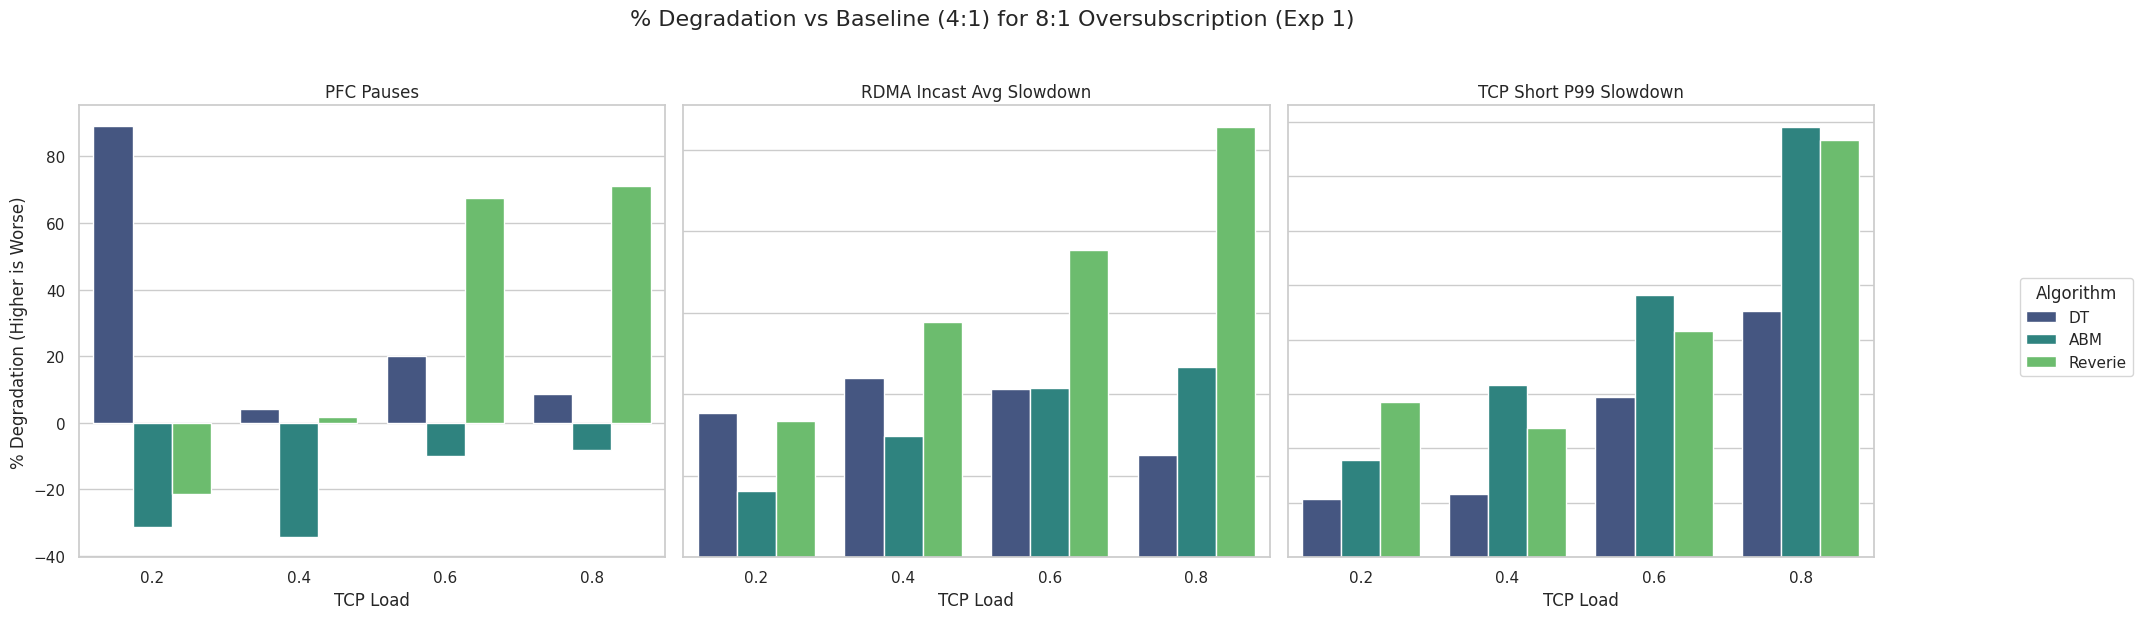


--- Plotting Exp 1 Degradation: 16:1 vs 4:1 Baseline ---


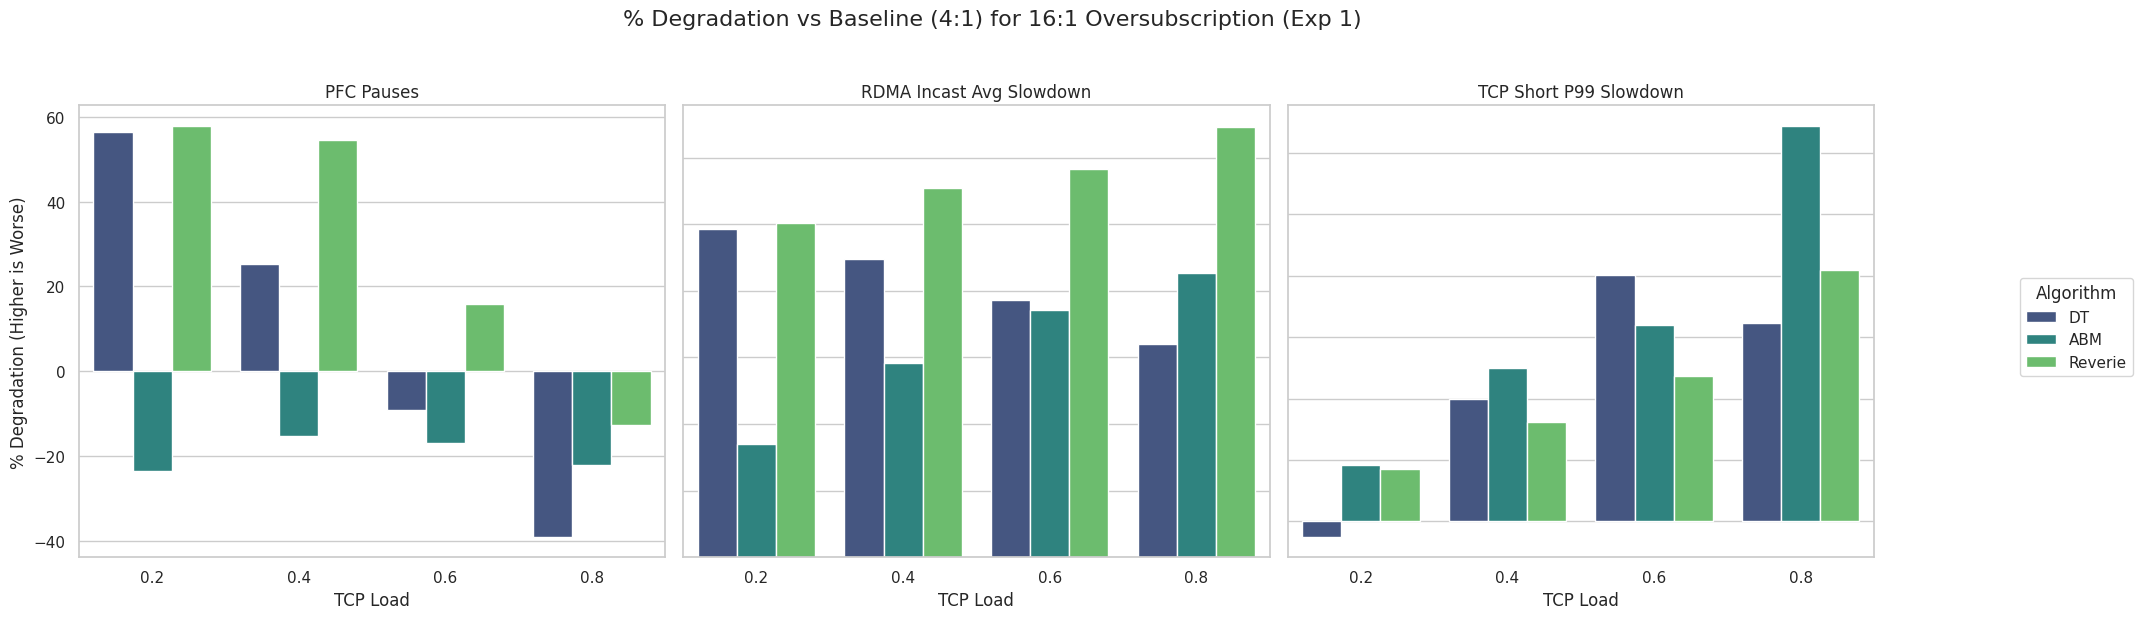

In [13]:
# --- Cell 4: Plotting Combined Degradation ---

def plot_combined_degradation(degradation_data, oversub_comparison, load_col, algo_col, metric_titles):
    """
    Generates a figure with three horizontal bar plots for the calculated degradation
    of the provided metrics. Handles cases where one or more metrics have no data.
    """
    metrics_to_plot = [
        (metric_titles[0], degradation_data[0]),
        (metric_titles[1], degradation_data[1]),
        (metric_titles[2], degradation_data[2])
    ]

    # Check if *any* data is available across all metrics
    if all(df is None or df.empty for _, df in metrics_to_plot):
        print(f"Skipping combined plot for {oversub_comparison}: No valid degradation data for any metric.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False) # Create 1 row, 3 columns of subplots
    fig.suptitle(f'% Degradation vs Baseline (4:1) for {oversub_comparison}', fontsize=16, y=1.03)

    has_plotted_data = False # Flag to track if any subplot actually gets data

    for i, (plot_title, df_degradation) in enumerate(metrics_to_plot):
        ax = axes[i] # Select the current subplot axis
        if df_degradation is None or df_degradation.empty or df_degradation['degradation_%'].isnull().all():
            # Handle cases with no data or only NaN degradation values
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'{plot_title}\n(No Data)')
            ax.set_xlabel(load_col) # Set xlabel even if no data
            ax.set_ylabel('') # Clear y-label for empty plots
            ax.tick_params(axis='y', which='both', left=False, labelleft=False) # Hide y-axis ticks/labels
            ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True) # Keep x-axis ticks/labels if possible
            # Try to set x-axis labels based on load_col if possible from other plots
            if df_degradation is not None and load_col in df_degradation.columns:
                 unique_loads = sorted(df_degradation[load_col].unique())
                 ax.set_xticks(range(len(unique_loads)))
                 ax.set_xticklabels(unique_loads)
            ax.get_yaxis().set_visible(False) # Hide y-axis line too
        else:
            # Plot the data if it's valid
            sns.barplot(
                data=df_degradation,
                x=load_col,
                y='degradation_%',
                hue=algo_col,
                palette='viridis', # Choose a suitable color palette
                hue_order=algorithms, # Ensure consistent algorithm order
                ax=ax # Plot on the specific subplot axis
            )
            has_plotted_data = True # Mark that we have plotted something

            ax.set_title(f'{plot_title}')
            ax.set_xlabel(load_col)
            if i == 0: # Only show y-axis label on the first plot
                 ax.set_ylabel('% Degradation (Higher is Worse)')
            else:
                 ax.set_ylabel('') # Remove y-label from subsequent plots
                 ax.tick_params(axis='y', which='both', left=False, labelleft=False) # Hide y-axis ticks/labels for subsequent plots

            # Attempt to remove legend from subplot (might already be removed if no data plotted)
            if ax.get_legend() is not None:
                ax.legend_.remove()

    # Add a single legend for the whole figure only if data was plotted
    if has_plotted_data:
        # Find the first axis that actually has plotted data to get handles/labels
        legend_ax = None
        for ax in axes:
            # Check if the axis has any bars plotted
            if len(ax.patches) > 0 :
                 legend_ax = ax
                 break

        if legend_ax is not None:
             handles, labels = legend_ax.get_legend_handles_labels() # Get legend info
             if handles and labels: # Ensure we got valid handles/labels
                fig.legend(handles, labels, title=algo_col, bbox_to_anchor=(1.01, 0.5), loc='center left')
             else:
                 print(f"Warning: Could not retrieve legend handles/labels for {oversub_comparison}.")
        else:
            # This case should ideally not happen if has_plotted_data is True, but as a fallback:
            print(f"Warning: No subplot with plottable data found to generate legend for {oversub_comparison}.")
    else:
         print(f"Info: No legend generated for {oversub_comparison} as no data was plotted.")


    plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for figure title and legend
    plt.show()

# --- Plot for 8:1 vs 4:1 (Exp 1 Data) ---
print("\n--- Plotting Exp 1 Degradation: 8:1 vs 4:1 Baseline ---")
plot_combined_degradation(
    degradation_data=[
        degradation_8_vs_4_pfc,
        degradation_8_vs_4_rdma_incast_avg,
        degradation_8_vs_4_tcp_short_p99
    ],
    oversub_comparison="8:1 Oversubscription (Exp 1)", # Added Exp number for clarity
    load_col=load_col, # Use Exp 1 load col
    algo_col=algo_col,
    metric_titles=["PFC Pauses", "RDMA Incast Avg Slowdown", "TCP Short P99 Slowdown"] # Titles for Exp 1 metrics
)

# --- Plot for 16:1 vs 4:1 (Exp 1 Data) ---
print("\n--- Plotting Exp 1 Degradation: 16:1 vs 4:1 Baseline ---")
plot_combined_degradation(
    degradation_data=[
        degradation_16_vs_4_pfc,
        degradation_16_vs_4_rdma_incast_avg,
        degradation_16_vs_4_tcp_short_p99
    ],
    oversub_comparison="16:1 Oversubscription (Exp 1)", # Added Exp number for clarity
    load_col=load_col, # Use Exp 1 load col
    algo_col=algo_col,
    metric_titles=["PFC Pauses", "RDMA Incast Avg Slowdown", "TCP Short P99 Slowdown"] # Titles for Exp 1 metrics
)


============================== Experiment 2 Analysis ==============================

Loading data for Experiment 2 (exp2_rdma_burst_with_tcp_bg.csv)...
Experiment 2 data loaded successfully.

Calculating degradation for Experiment 2...

--- Plotting Exp 2 Degradation: 8:1 vs 4:1 Baseline ---


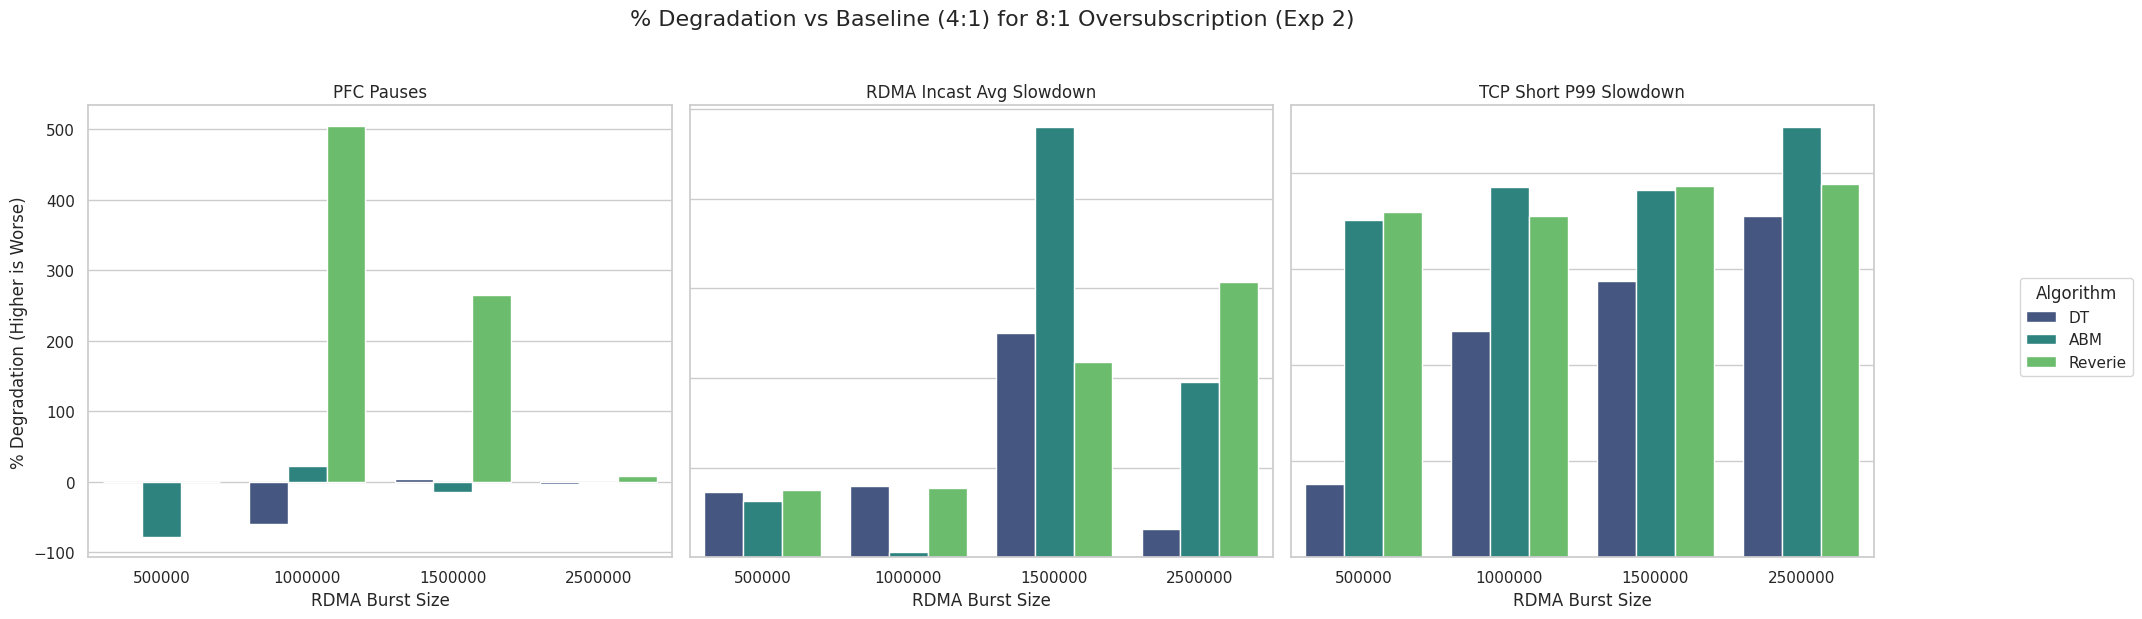


--- Plotting Exp 2 Degradation: 16:1 vs 4:1 Baseline ---


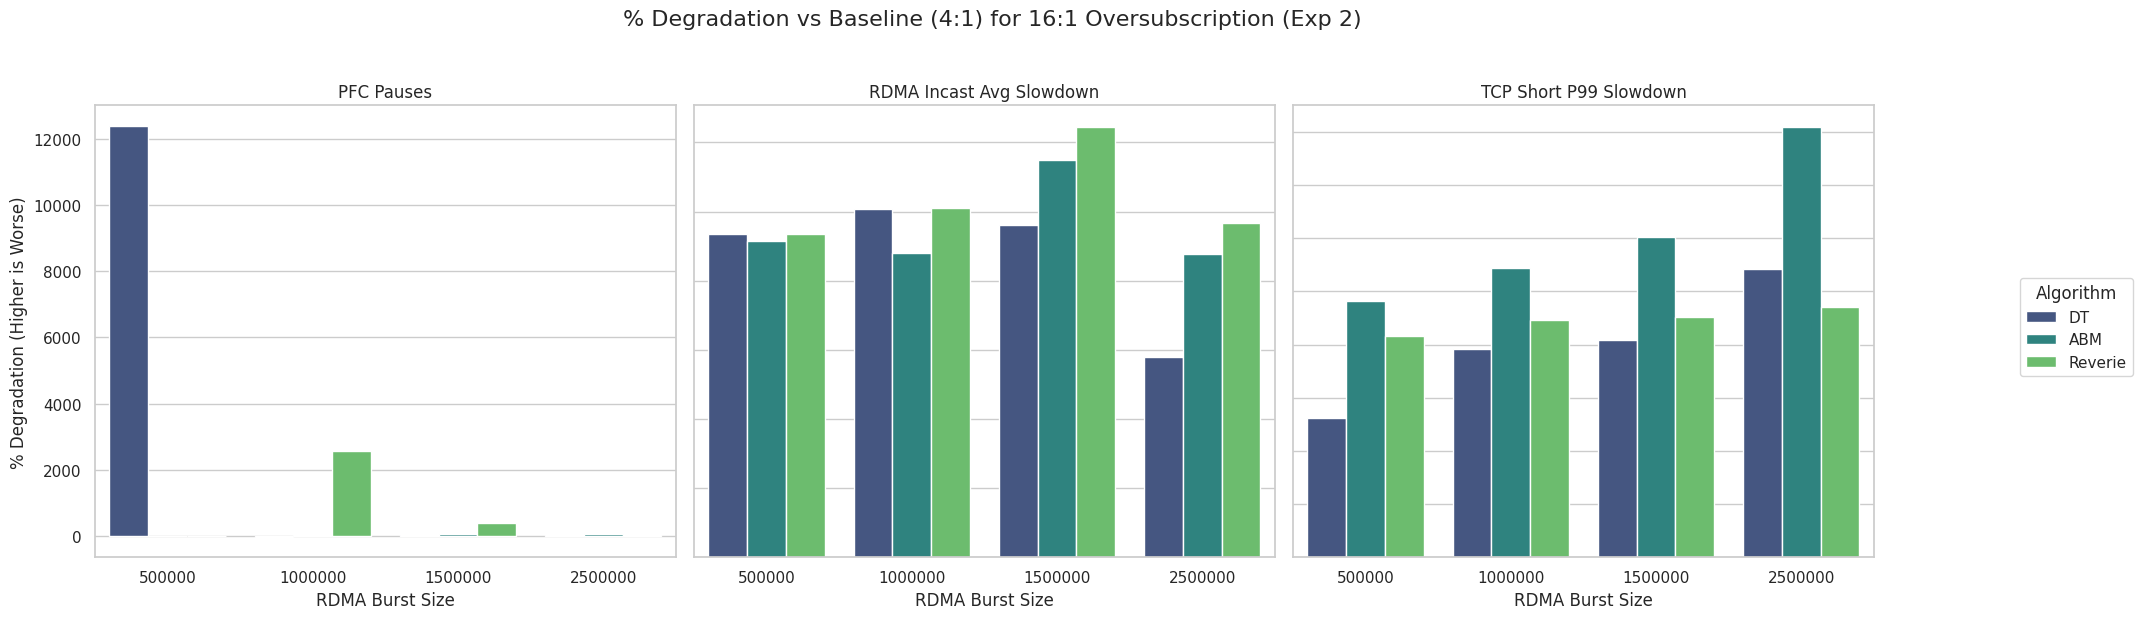


============================== End Experiment 2 Analysis ==============================


In [14]:

# --- Cell 5: Experiment 2 Analysis (RDMA Burst Size Impact) ---

print("\n" + "="*30 + " Experiment 2 Analysis " + "="*30)

# --- Configuration for Experiment 2 ---
exp2_filename = "exp2_rdma_burst_with_tcp_bg.csv"

# Columns for Experiment 2
exp2_load_col = "RDMA Burst Size" # X-axis is RDMA Burst Size for Exp 2
exp2_algo_col = "Algorithm"
# Metrics based on user request and Exp 2 availability:
exp2_metric_pfc = "PFC Pauses"
exp2_metric_rdma_incast_avg = "RDMA Incast FCT Slowdown Avg"
exp2_metric_tcp_short_p99 = "TCP Short FCT Slowdown 99%"

# List of all metric columns needed for Exp 2
exp2_metric_cols = [exp2_metric_pfc, exp2_metric_rdma_incast_avg, exp2_metric_tcp_short_p99]

# --- Data Loading for Experiment 2 ---
print(f"\nLoading data for Experiment 2 ({exp2_filename})...")
# Construct full paths to the specific CSV files for Exp 2
csv_path_exp2_4_1 = os.path.join(results_path_4_1, exp2_filename)
csv_path_exp2_8_1 = os.path.join(results_path_8_1, exp2_filename)
csv_path_exp2_16_1 = os.path.join(results_path_16_1, exp2_filename)

df_exp2_4_1 = load_and_prepare_data(csv_path_exp2_4_1, exp2_load_col, exp2_algo_col, exp2_metric_cols)
df_exp2_8_1 = load_and_prepare_data(csv_path_exp2_8_1, exp2_load_col, exp2_algo_col, exp2_metric_cols)
df_exp2_16_1 = load_and_prepare_data(csv_path_exp2_16_1, exp2_load_col, exp2_algo_col, exp2_metric_cols)

# Check if all dataframes loaded successfully
if df_exp2_4_1 is None or df_exp2_8_1 is None or df_exp2_16_1 is None:
    print("Error loading data for Experiment 2. Skipping analysis.")
else:
    print("Experiment 2 data loaded successfully.")

    # --- Degradation Calculation for Experiment 2 ---
    print("\nCalculating degradation for Experiment 2...")
    # 8:1 vs 4:1
    degradation_exp2_8_vs_4_pfc = calculate_degradation(df_exp2_4_1, df_exp2_8_1, exp2_metric_pfc, exp2_load_col, exp2_algo_col)
    degradation_exp2_8_vs_4_rdma_incast_avg = calculate_degradation(df_exp2_4_1, df_exp2_8_1, exp2_metric_rdma_incast_avg, exp2_load_col, exp2_algo_col)
    degradation_exp2_8_vs_4_tcp_short_p99 = calculate_degradation(df_exp2_4_1, df_exp2_8_1, exp2_metric_tcp_short_p99, exp2_load_col, exp2_algo_col)

    # 16:1 vs 4:1
    degradation_exp2_16_vs_4_pfc = calculate_degradation(df_exp2_4_1, df_exp2_16_1, exp2_metric_pfc, exp2_load_col, exp2_algo_col)
    degradation_exp2_16_vs_4_rdma_incast_avg = calculate_degradation(df_exp2_4_1, df_exp2_16_1, exp2_metric_rdma_incast_avg, exp2_load_col, exp2_algo_col)
    degradation_exp2_16_vs_4_tcp_short_p99 = calculate_degradation(df_exp2_4_1, df_exp2_16_1, exp2_metric_tcp_short_p99, exp2_load_col, exp2_algo_col)

    # Optional: Print calculated degradation dataframes
    # print("\nExp 2 Degradation (8:1 vs 4:1) - PFC Pauses:\n", degradation_exp2_8_vs_4_pfc)
    # print("\nExp 2 Degradation (16:1 vs 4:1) - PFC Pauses:\n", degradation_exp2_16_vs_4_pfc)

    # --- Plotting Combined Degradation for Experiment 2 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 2 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp2_8_vs_4_pfc,
            degradation_exp2_8_vs_4_rdma_incast_avg,
            degradation_exp2_8_vs_4_tcp_short_p99
        ],
        oversub_comparison="8:1 Oversubscription (Exp 2)",
        load_col=exp2_load_col, # Use the correct x-axis column name
        algo_col=exp2_algo_col,
        metric_titles=["PFC Pauses", "RDMA Incast Avg Slowdown", "TCP Short P99 Slowdown"] # Titles for Exp 2 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 2 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp2_16_vs_4_pfc,
            degradation_exp2_16_vs_4_rdma_incast_avg,
            degradation_exp2_16_vs_4_tcp_short_p99
        ],
        oversub_comparison="16:1 Oversubscription (Exp 2)",
        load_col=exp2_load_col, # Use the correct x-axis column name
        algo_col=exp2_algo_col,
        metric_titles=["PFC Pauses", "RDMA Incast Avg Slowdown", "TCP Short P99 Slowdown"] # Titles for Exp 2 metrics
    )

print("\n" + "="*30 + " End Experiment 2 Analysis " + "="*30)




============================== Experiment 3 Analysis ==============================

Loading data for Experiment 3 (exp3_rdma_load_on_tcp_burst.csv)...
Experiment 3 data loaded successfully.

Calculating degradation for Experiment 3...

--- Plotting Exp 3 Degradation: 8:1 vs 4:1 Baseline ---


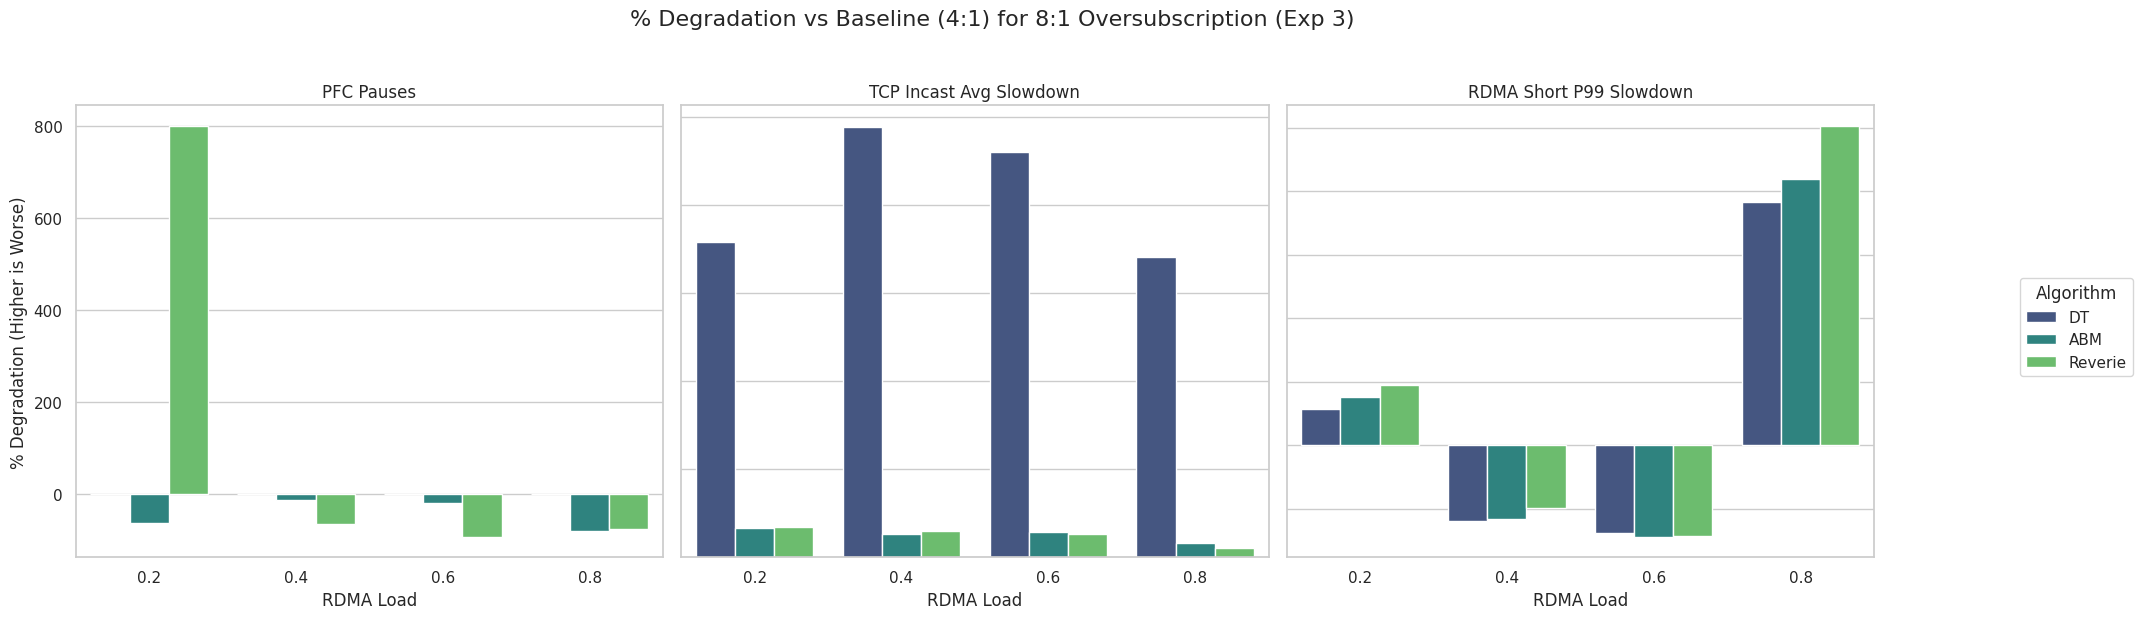


--- Plotting Exp 3 Degradation: 16:1 vs 4:1 Baseline ---


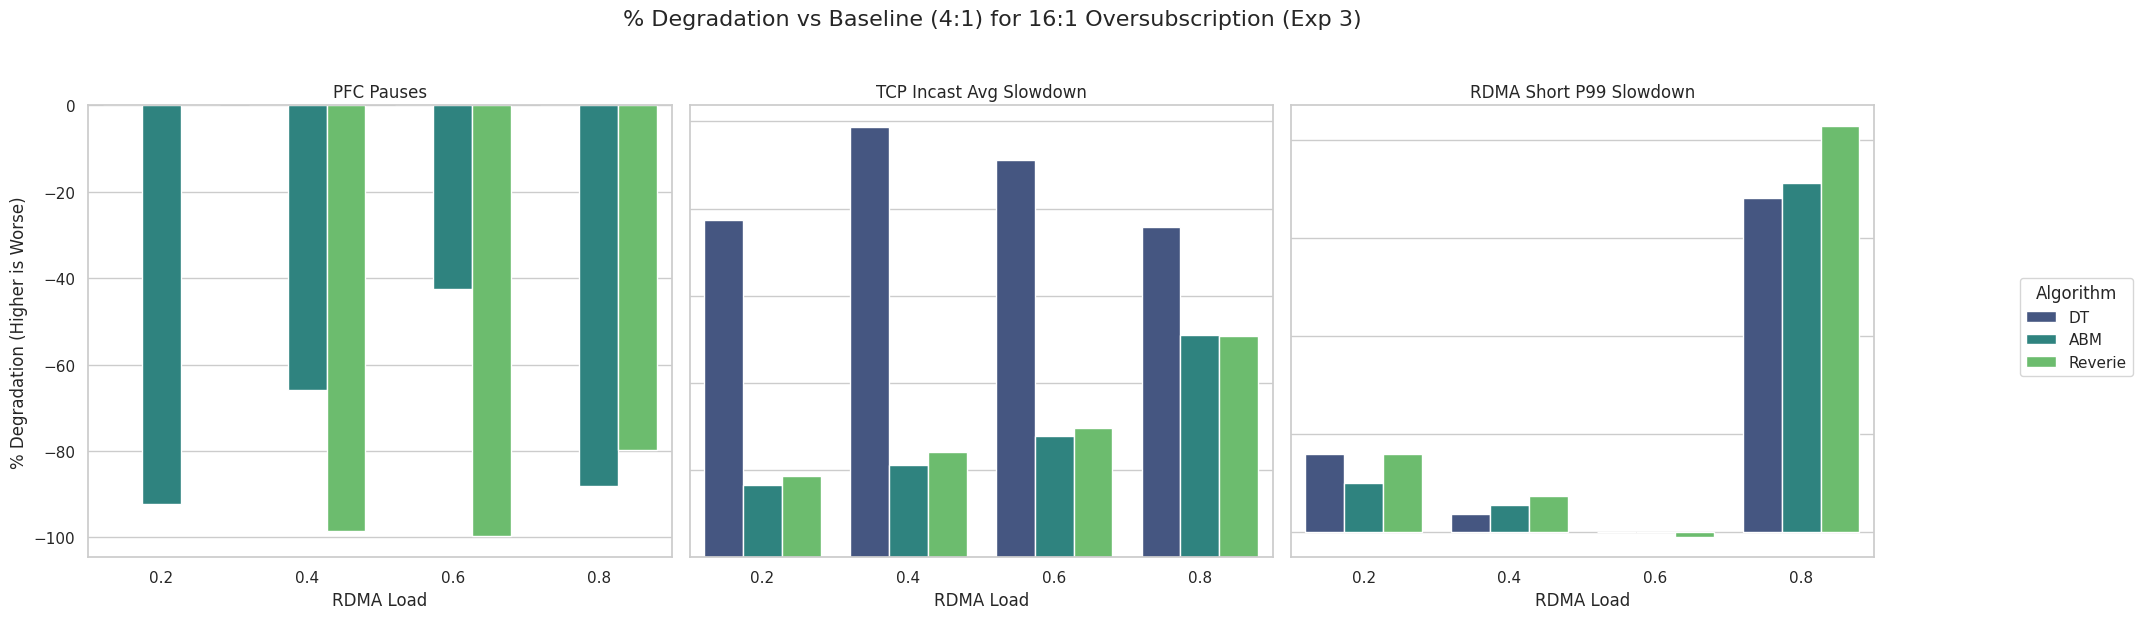


============================== End Experiment 3 Analysis ==============================


In [15]:
# --- Cell 6: Experiment 3 Analysis (RDMA Load Impact on TCP Burst) ---

print("\n" + "="*30 + " Experiment 3 Analysis " + "="*30)

# --- Configuration for Experiment 3 ---
exp3_filename = "exp3_rdma_load_on_tcp_burst.csv"

# Columns for Experiment 3
exp3_load_col = "RDMA Load" # X-axis is RDMA Load for Exp 3
exp3_algo_col = "Algorithm"
# Metrics based on user request and Exp 3 availability:
exp3_metric_pfc = "PFC Pauses"
exp3_metric_tcp_incast_avg = "TCP Incast FCT Slowdown Avg" # Note: TCP incast for Exp 3
exp3_metric_rdma_short_p99 = "RDMA Short FCT Slowdown 99%" # Note: RDMA short background for Exp 3

# List of all metric columns needed for Exp 3
exp3_metric_cols = [exp3_metric_pfc, exp3_metric_tcp_incast_avg, exp3_metric_rdma_short_p99]

# --- Data Loading for Experiment 3 ---
print(f"\nLoading data for Experiment 3 ({exp3_filename})...")
# Construct full paths to the specific CSV files for Exp 3
csv_path_exp3_4_1 = os.path.join(results_path_4_1, exp3_filename)
csv_path_exp3_8_1 = os.path.join(results_path_8_1, exp3_filename)
csv_path_exp3_16_1 = os.path.join(results_path_16_1, exp3_filename)

df_exp3_4_1 = load_and_prepare_data(csv_path_exp3_4_1, exp3_load_col, exp3_algo_col, exp3_metric_cols)
df_exp3_8_1 = load_and_prepare_data(csv_path_exp3_8_1, exp3_load_col, exp3_algo_col, exp3_metric_cols)
df_exp3_16_1 = load_and_prepare_data(csv_path_exp3_16_1, exp3_load_col, exp3_algo_col, exp3_metric_cols)

# Check if all dataframes loaded successfully
if df_exp3_4_1 is None or df_exp3_8_1 is None or df_exp3_16_1 is None:
    print("Error loading data for Experiment 3. Skipping analysis.")
else:
    print("Experiment 3 data loaded successfully.")

    # --- Degradation Calculation for Experiment 3 ---
    print("\nCalculating degradation for Experiment 3...")
    # 8:1 vs 4:1
    degradation_exp3_8_vs_4_pfc = calculate_degradation(df_exp3_4_1, df_exp3_8_1, exp3_metric_pfc, exp3_load_col, exp3_algo_col)
    degradation_exp3_8_vs_4_tcp_incast_avg = calculate_degradation(df_exp3_4_1, df_exp3_8_1, exp3_metric_tcp_incast_avg, exp3_load_col, exp3_algo_col)
    degradation_exp3_8_vs_4_rdma_short_p99 = calculate_degradation(df_exp3_4_1, df_exp3_8_1, exp3_metric_rdma_short_p99, exp3_load_col, exp3_algo_col)

    # 16:1 vs 4:1
    degradation_exp3_16_vs_4_pfc = calculate_degradation(df_exp3_4_1, df_exp3_16_1, exp3_metric_pfc, exp3_load_col, exp3_algo_col)
    degradation_exp3_16_vs_4_tcp_incast_avg = calculate_degradation(df_exp3_4_1, df_exp3_16_1, exp3_metric_tcp_incast_avg, exp3_load_col, exp3_algo_col)
    degradation_exp3_16_vs_4_rdma_short_p99 = calculate_degradation(df_exp3_4_1, df_exp3_16_1, exp3_metric_rdma_short_p99, exp3_load_col, exp3_algo_col)

    # Optional: Print calculated degradation dataframes
    # print("\nExp 3 Degradation (8:1 vs 4:1) - PFC Pauses:\n", degradation_exp3_8_vs_4_pfc)
    # print("\nExp 3 Degradation (16:1 vs 4:1) - PFC Pauses:\n", degradation_exp3_16_vs_4_pfc)

    # --- Plotting Combined Degradation for Experiment 3 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 3 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp3_8_vs_4_pfc,
            degradation_exp3_8_vs_4_tcp_incast_avg, # Use TCP Incast Avg for Exp 3
            degradation_exp3_8_vs_4_rdma_short_p99 # Use RDMA Short P99 for Exp 3
        ],
        oversub_comparison="8:1 Oversubscription (Exp 3)",
        load_col=exp3_load_col, # Use the correct x-axis column name
        algo_col=exp3_algo_col,
        metric_titles=["PFC Pauses", "TCP Incast Avg Slowdown", "RDMA Short P99 Slowdown"] # Titles for Exp 3 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 3 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp3_16_vs_4_pfc,
            degradation_exp3_16_vs_4_tcp_incast_avg, # Use TCP Incast Avg for Exp 3
            degradation_exp3_16_vs_4_rdma_short_p99 # Use RDMA Short P99 for Exp 3
        ],
        oversub_comparison="16:1 Oversubscription (Exp 3)",
        load_col=exp3_load_col, # Use the correct x-axis column name
        algo_col=exp3_algo_col,
        metric_titles=["PFC Pauses", "TCP Incast Avg Slowdown", "RDMA Short P99 Slowdown"] # Titles for Exp 3 metrics
    )

print("\n" + "="*30 + " End Experiment 3 Analysis " + "="*30)





============================== Experiment 4 Analysis ==============================

Loading data for Experiment 4 (exp4_tcp_burst_with_rdma_bg.csv)...
Experiment 4 data loaded successfully.

Calculating degradation for Experiment 4...

--- Plotting Exp 4 Degradation: 8:1 vs 4:1 Baseline ---


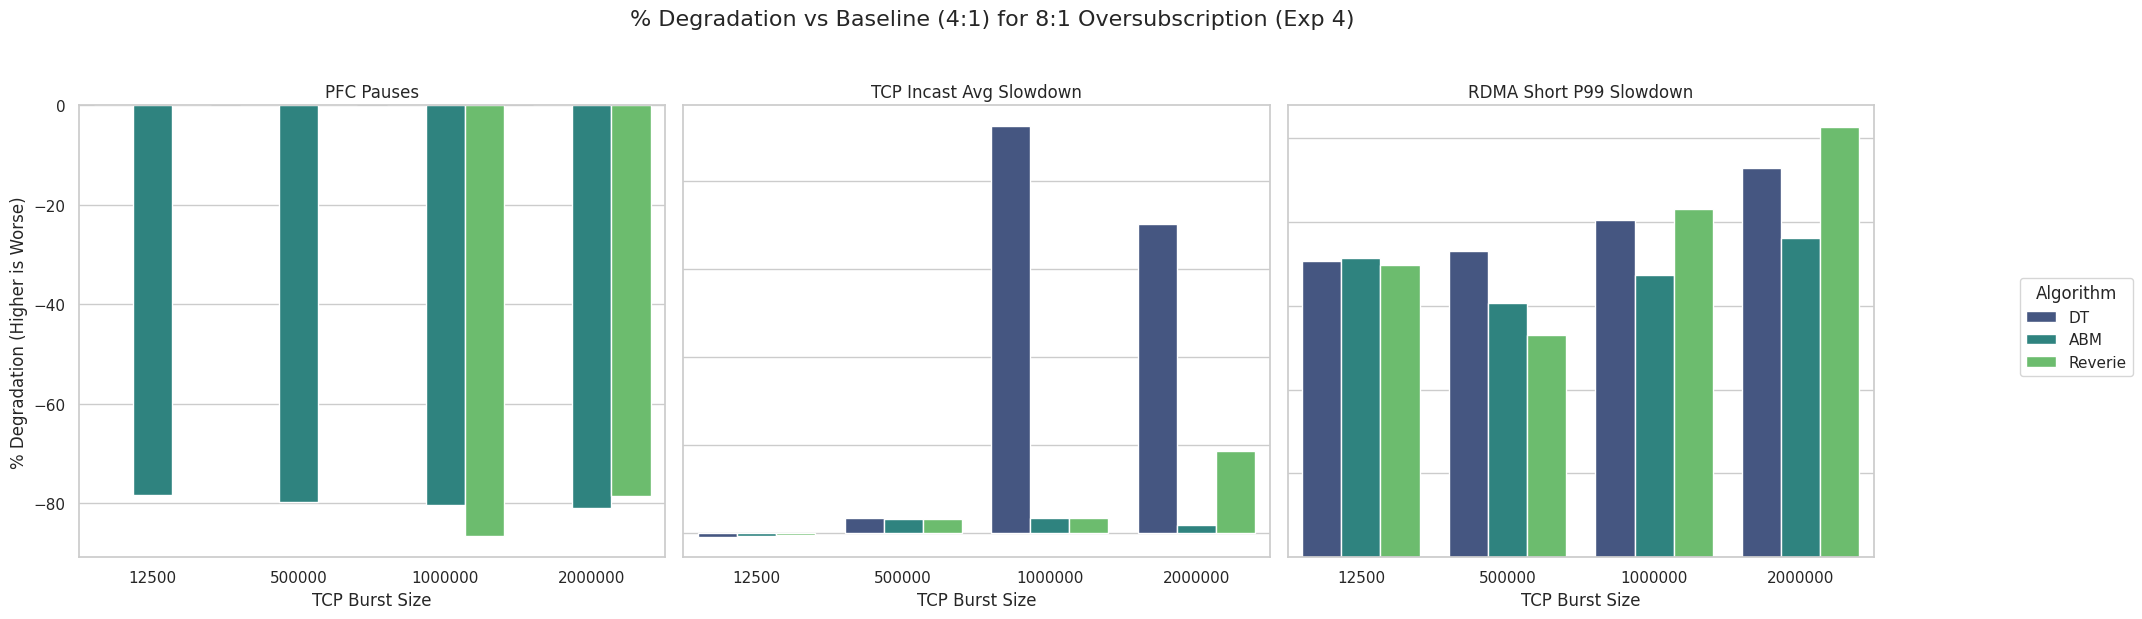


--- Plotting Exp 4 Degradation: 16:1 vs 4:1 Baseline ---


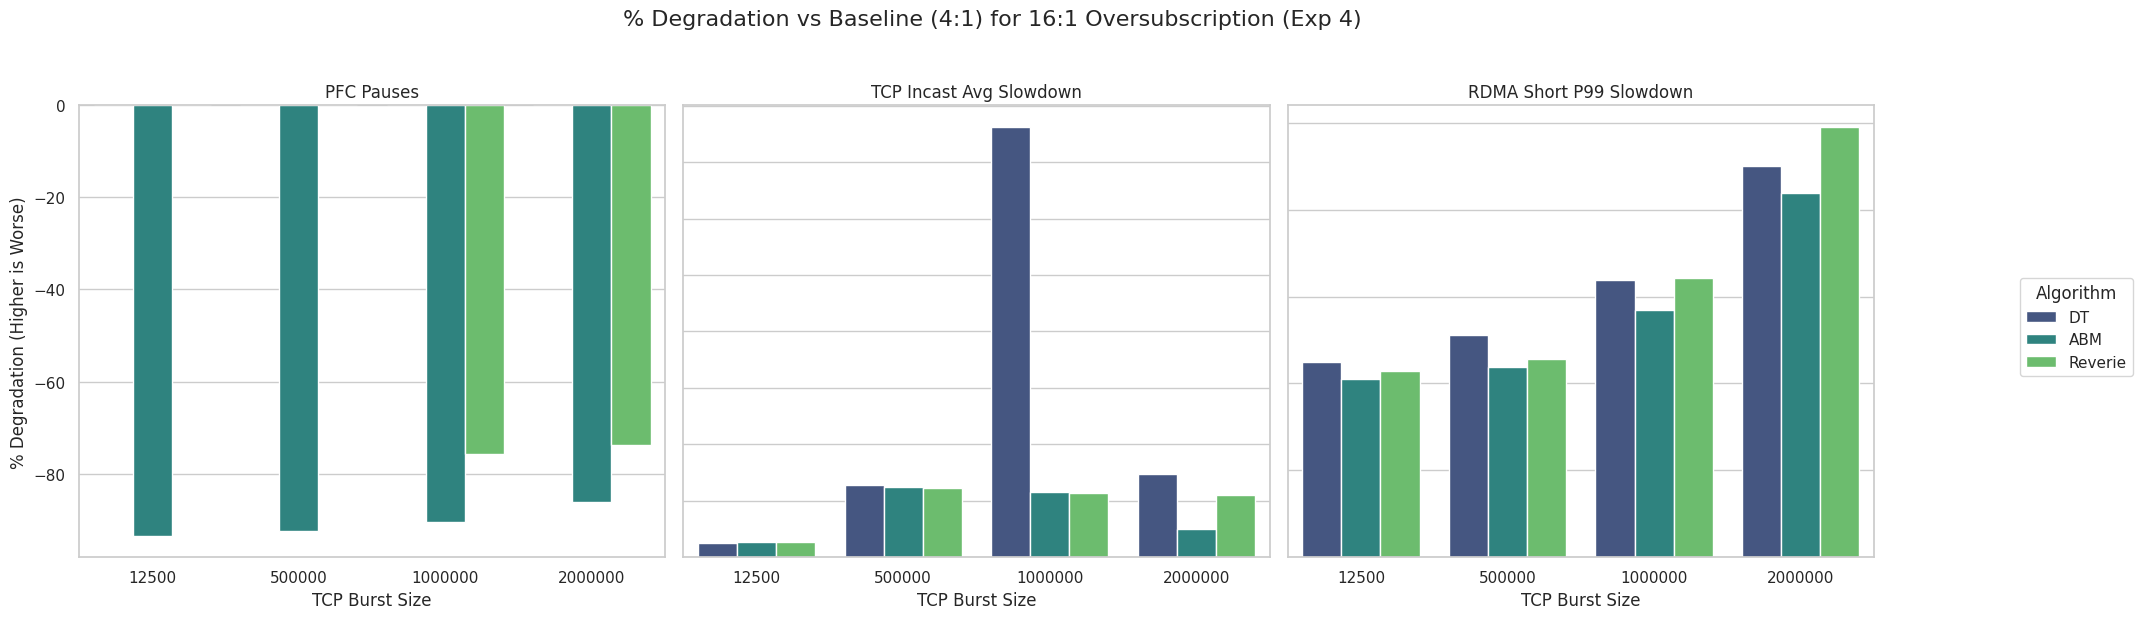


============================== End Experiment 4 Analysis ==============================


In [16]:
# --- Cell 7: Experiment 4 Analysis (TCP Burst Size Impact) ---

print("\n" + "="*30 + " Experiment 4 Analysis " + "="*30)

# --- Configuration for Experiment 4 ---
exp4_filename = "exp4_tcp_burst_with_rdma_bg.csv"

# Columns for Experiment 4
exp4_load_col = "TCP Burst Size" # X-axis is TCP Burst Size for Exp 4
exp4_algo_col = "Algorithm"
# Metrics based on user request and Exp 4 availability:
exp4_metric_pfc = "PFC Pauses"
exp4_metric_tcp_incast_avg = "TCP Incast FCT Slowdown Avg" # Note: TCP incast for Exp 4
exp4_metric_rdma_short_p99 = "RDMA Short FCT Slowdown 99%" # Note: RDMA short background for Exp 4

# List of all metric columns needed for Exp 4
exp4_metric_cols = [exp4_metric_pfc, exp4_metric_tcp_incast_avg, exp4_metric_rdma_short_p99]

# --- Data Loading for Experiment 4 ---
print(f"\nLoading data for Experiment 4 ({exp4_filename})...")
# Construct full paths to the specific CSV files for Exp 4
csv_path_exp4_4_1 = os.path.join(results_path_4_1, exp4_filename)
csv_path_exp4_8_1 = os.path.join(results_path_8_1, exp4_filename)
csv_path_exp4_16_1 = os.path.join(results_path_16_1, exp4_filename)

df_exp4_4_1 = load_and_prepare_data(csv_path_exp4_4_1, exp4_load_col, exp4_algo_col, exp4_metric_cols)
df_exp4_8_1 = load_and_prepare_data(csv_path_exp4_8_1, exp4_load_col, exp4_algo_col, exp4_metric_cols)
df_exp4_16_1 = load_and_prepare_data(csv_path_exp4_16_1, exp4_load_col, exp4_algo_col, exp4_metric_cols)

# Check if all dataframes loaded successfully
if df_exp4_4_1 is None or df_exp4_8_1 is None or df_exp4_16_1 is None:
    print("Error loading data for Experiment 4. Skipping analysis.")
else:
    print("Experiment 4 data loaded successfully.")

    # --- Degradation Calculation for Experiment 4 ---
    print("\nCalculating degradation for Experiment 4...")
    # 8:1 vs 4:1
    degradation_exp4_8_vs_4_pfc = calculate_degradation(df_exp4_4_1, df_exp4_8_1, exp4_metric_pfc, exp4_load_col, exp4_algo_col)
    degradation_exp4_8_vs_4_tcp_incast_avg = calculate_degradation(df_exp4_4_1, df_exp4_8_1, exp4_metric_tcp_incast_avg, exp4_load_col, exp4_algo_col)
    degradation_exp4_8_vs_4_rdma_short_p99 = calculate_degradation(df_exp4_4_1, df_exp4_8_1, exp4_metric_rdma_short_p99, exp4_load_col, exp4_algo_col)

    # 16:1 vs 4:1
    degradation_exp4_16_vs_4_pfc = calculate_degradation(df_exp4_4_1, df_exp4_16_1, exp4_metric_pfc, exp4_load_col, exp4_algo_col)
    degradation_exp4_16_vs_4_tcp_incast_avg = calculate_degradation(df_exp4_4_1, df_exp4_16_1, exp4_metric_tcp_incast_avg, exp4_load_col, exp4_algo_col)
    degradation_exp4_16_vs_4_rdma_short_p99 = calculate_degradation(df_exp4_4_1, df_exp4_16_1, exp4_metric_rdma_short_p99, exp4_load_col, exp4_algo_col)

    # Optional: Print calculated degradation dataframes
    # print("\nExp 4 Degradation (8:1 vs 4:1) - PFC Pauses:\n", degradation_exp4_8_vs_4_pfc)
    # print("\nExp 4 Degradation (16:1 vs 4:1) - PFC Pauses:\n", degradation_exp4_16_vs_4_pfc)

    # --- Plotting Combined Degradation for Experiment 4 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 4 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp4_8_vs_4_pfc,
            degradation_exp4_8_vs_4_tcp_incast_avg, # Use TCP Incast Avg for Exp 4
            degradation_exp4_8_vs_4_rdma_short_p99 # Use RDMA Short P99 for Exp 4
        ],
        oversub_comparison="8:1 Oversubscription (Exp 4)",
        load_col=exp4_load_col, # Use the correct x-axis column name
        algo_col=exp4_algo_col,
        metric_titles=["PFC Pauses", "TCP Incast Avg Slowdown", "RDMA Short P99 Slowdown"] # Titles for Exp 4 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 4 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp4_16_vs_4_pfc,
            degradation_exp4_16_vs_4_tcp_incast_avg, # Use TCP Incast Avg for Exp 4
            degradation_exp4_16_vs_4_rdma_short_p99 # Use RDMA Short P99 for Exp 4
        ],
        oversub_comparison="16:1 Oversubscription (Exp 4)",
        load_col=exp4_load_col, # Use the correct x-axis column name
        algo_col=exp4_algo_col,
        metric_titles=["PFC Pauses", "TCP Incast Avg Slowdown", "RDMA Short P99 Slowdown"] # Titles for Exp 4 metrics
    )

print("\n" + "="*30 + " End Experiment 4 Analysis " + "="*30)







============================== Experiment 7 Analysis ==============================

Loading data for Experiment 7 (exp7_pure_rdma_load_impact.csv)...
Experiment 7 data loaded successfully.

Calculating degradation for Experiment 7...

--- Plotting Exp 7 Degradation: 8:1 vs 4:1 Baseline ---


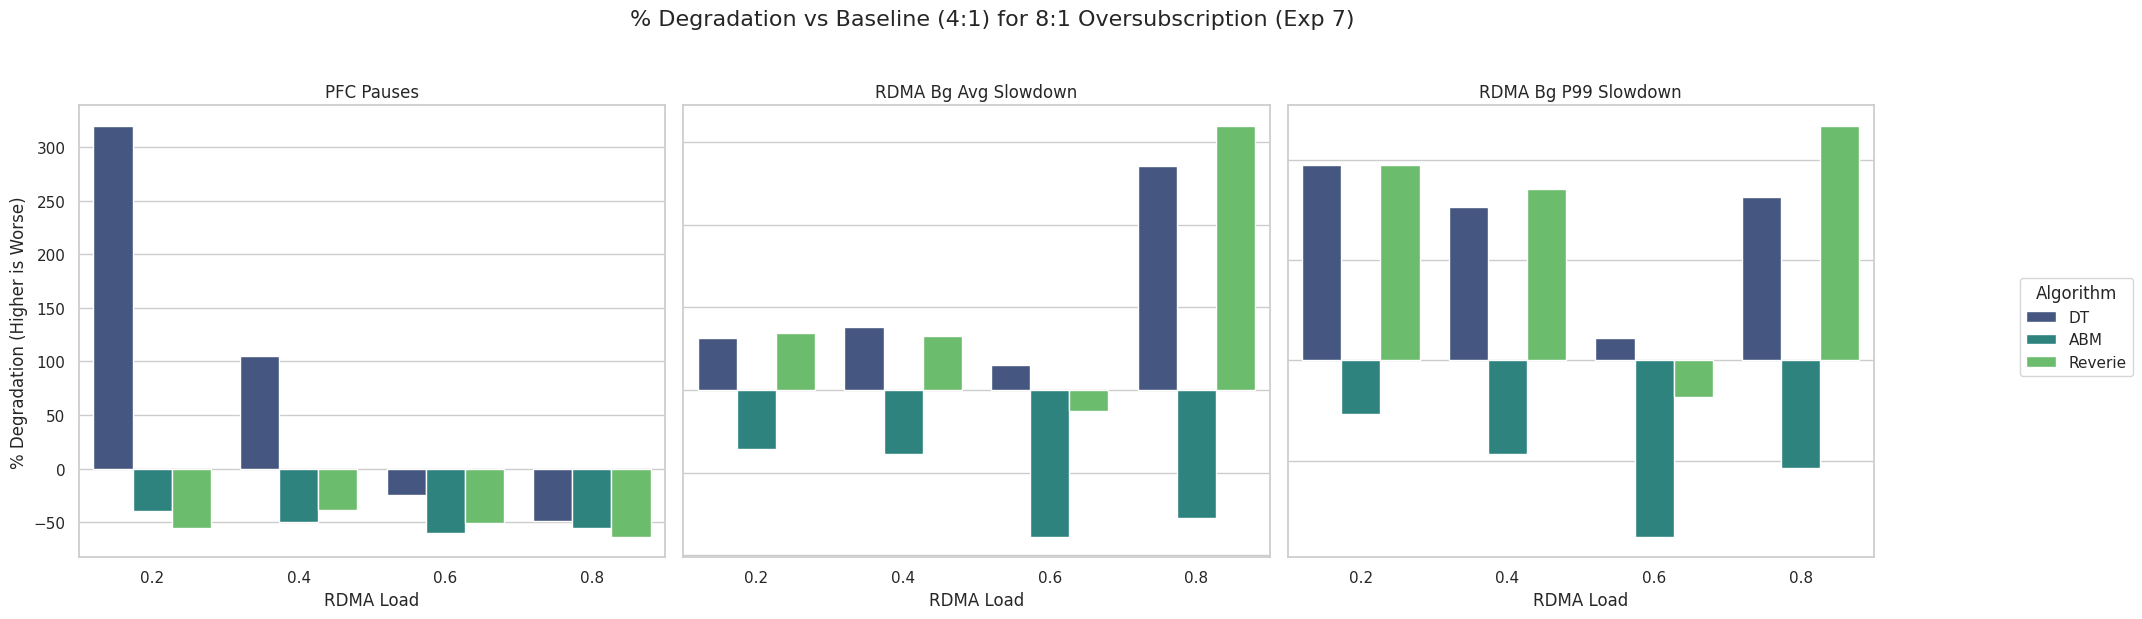


--- Plotting Exp 7 Degradation: 16:1 vs 4:1 Baseline ---


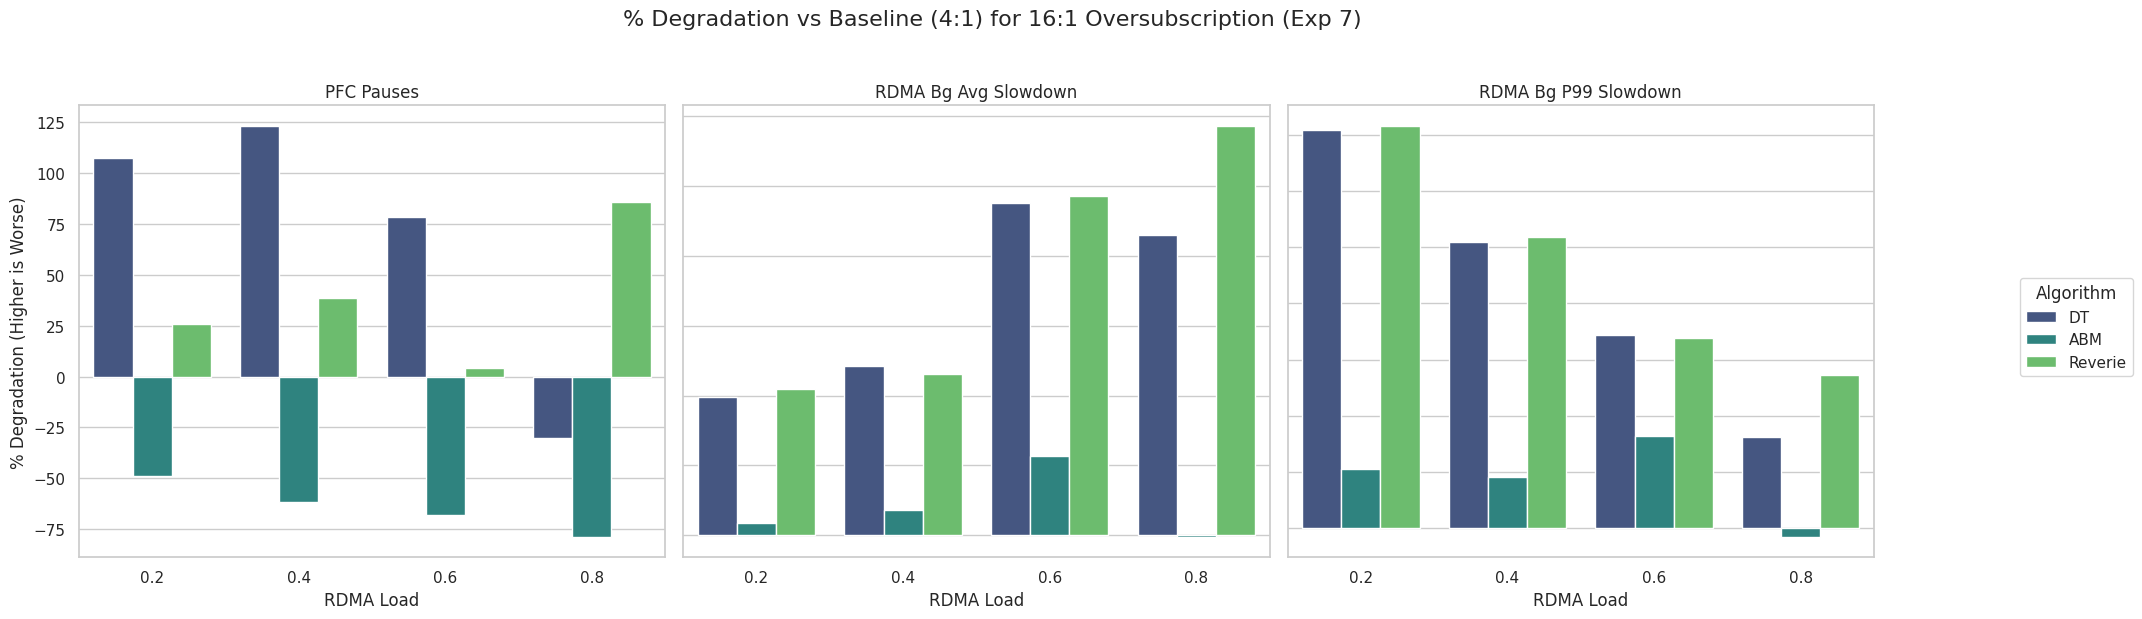


============================== End Experiment 7 Analysis ==============================


In [17]:

# --- Cell 8: Experiment 7 Analysis (Pure RDMA Load) ---

print("\n" + "="*30 + " Experiment 7 Analysis " + "="*30)

# --- Configuration for Experiment 7 ---
exp7_filename = "exp7_pure_rdma_load_impact.csv"

# Columns for Experiment 7
exp7_load_col = "RDMA Load" # X-axis is RDMA Load for Exp 7
exp7_algo_col = "Algorithm"
# Metrics based on user request and Exp 7 availability:
exp7_metric_pfc = "PFC Pauses"
# Using RDMA Background metrics as stand-ins for "incast" and "short background"
exp7_metric_rdma_bg_avg = "RDMA Background FCT Slowdown Avg"
exp7_metric_rdma_bg_p99 = "RDMA Background FCT Slowdown 99%"

# List of all metric columns needed for Exp 7
exp7_metric_cols = [exp7_metric_pfc, exp7_metric_rdma_bg_avg, exp7_metric_rdma_bg_p99]

# --- Data Loading for Experiment 7 ---
print(f"\nLoading data for Experiment 7 ({exp7_filename})...")
# Construct full paths to the specific CSV files for Exp 7
csv_path_exp7_4_1 = os.path.join(results_path_4_1, exp7_filename)
csv_path_exp7_8_1 = os.path.join(results_path_8_1, exp7_filename)
csv_path_exp7_16_1 = os.path.join(results_path_16_1, exp7_filename)

df_exp7_4_1 = load_and_prepare_data(csv_path_exp7_4_1, exp7_load_col, exp7_algo_col, exp7_metric_cols)
df_exp7_8_1 = load_and_prepare_data(csv_path_exp7_8_1, exp7_load_col, exp7_algo_col, exp7_metric_cols)
df_exp7_16_1 = load_and_prepare_data(csv_path_exp7_16_1, exp7_load_col, exp7_algo_col, exp7_metric_cols)

# Check if all dataframes loaded successfully
if df_exp7_4_1 is None or df_exp7_8_1 is None or df_exp7_16_1 is None:
    print("Error loading data for Experiment 7. Skipping analysis.")
else:
    print("Experiment 7 data loaded successfully.")

    # --- Degradation Calculation for Experiment 7 ---
    print("\nCalculating degradation for Experiment 7...")
    # 8:1 vs 4:1
    degradation_exp7_8_vs_4_pfc = calculate_degradation(df_exp7_4_1, df_exp7_8_1, exp7_metric_pfc, exp7_load_col, exp7_algo_col)
    degradation_exp7_8_vs_4_rdma_bg_avg = calculate_degradation(df_exp7_4_1, df_exp7_8_1, exp7_metric_rdma_bg_avg, exp7_load_col, exp7_algo_col)
    degradation_exp7_8_vs_4_rdma_bg_p99 = calculate_degradation(df_exp7_4_1, df_exp7_8_1, exp7_metric_rdma_bg_p99, exp7_load_col, exp7_algo_col)

    # 16:1 vs 4:1
    degradation_exp7_16_vs_4_pfc = calculate_degradation(df_exp7_4_1, df_exp7_16_1, exp7_metric_pfc, exp7_load_col, exp7_algo_col)
    degradation_exp7_16_vs_4_rdma_bg_avg = calculate_degradation(df_exp7_4_1, df_exp7_16_1, exp7_metric_rdma_bg_avg, exp7_load_col, exp7_algo_col)
    degradation_exp7_16_vs_4_rdma_bg_p99 = calculate_degradation(df_exp7_4_1, df_exp7_16_1, exp7_metric_rdma_bg_p99, exp7_load_col, exp7_algo_col)

    # --- Plotting Combined Degradation for Experiment 7 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 7 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp7_8_vs_4_pfc,
            degradation_exp7_8_vs_4_rdma_bg_avg,
            degradation_exp7_8_vs_4_rdma_bg_p99
        ],
        oversub_comparison="8:1 Oversubscription (Exp 7)",
        load_col=exp7_load_col,
        algo_col=exp7_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "RDMA Bg P99 Slowdown"] # Titles for Exp 7 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 7 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp7_16_vs_4_pfc,
            degradation_exp7_16_vs_4_rdma_bg_avg,
            degradation_exp7_16_vs_4_rdma_bg_p99
        ],
        oversub_comparison="16:1 Oversubscription (Exp 7)",
        load_col=exp7_load_col,
        algo_col=exp7_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "RDMA Bg P99 Slowdown"] # Titles for Exp 7 metrics
    )

print("\n" + "="*30 + " End Experiment 7 Analysis " + "="*30)





============================== Experiment 8 Analysis ==============================

Loading data for Experiment 8 (exp8_pure_rdma_burst_impact.csv)...
Experiment 8 data loaded successfully.

Calculating degradation for Experiment 8...

--- Plotting Exp 8 Degradation: 8:1 vs 4:1 Baseline ---


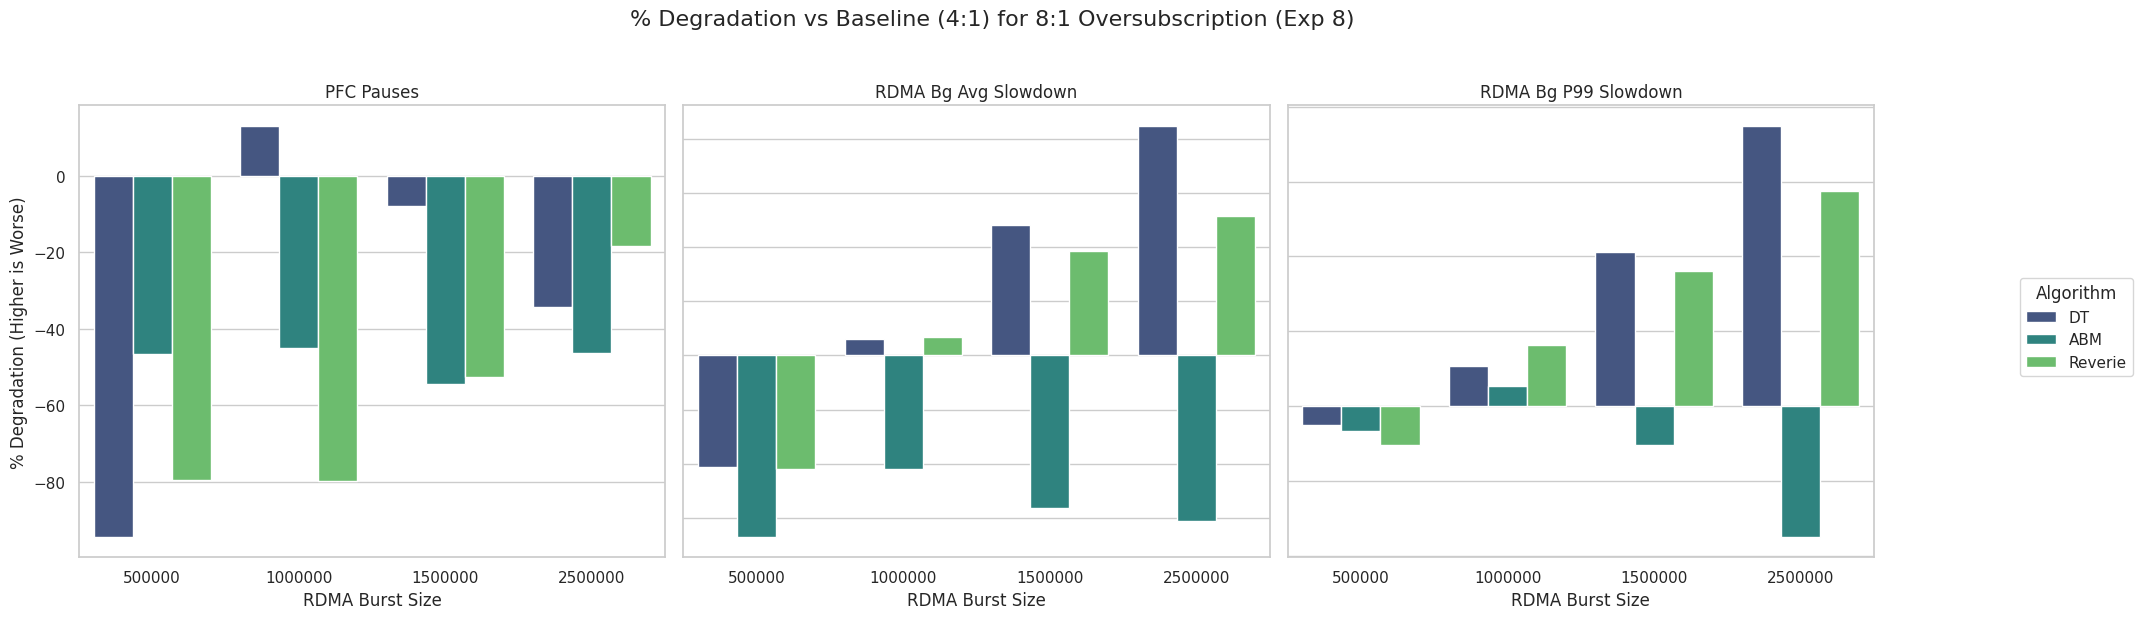


--- Plotting Exp 8 Degradation: 16:1 vs 4:1 Baseline ---


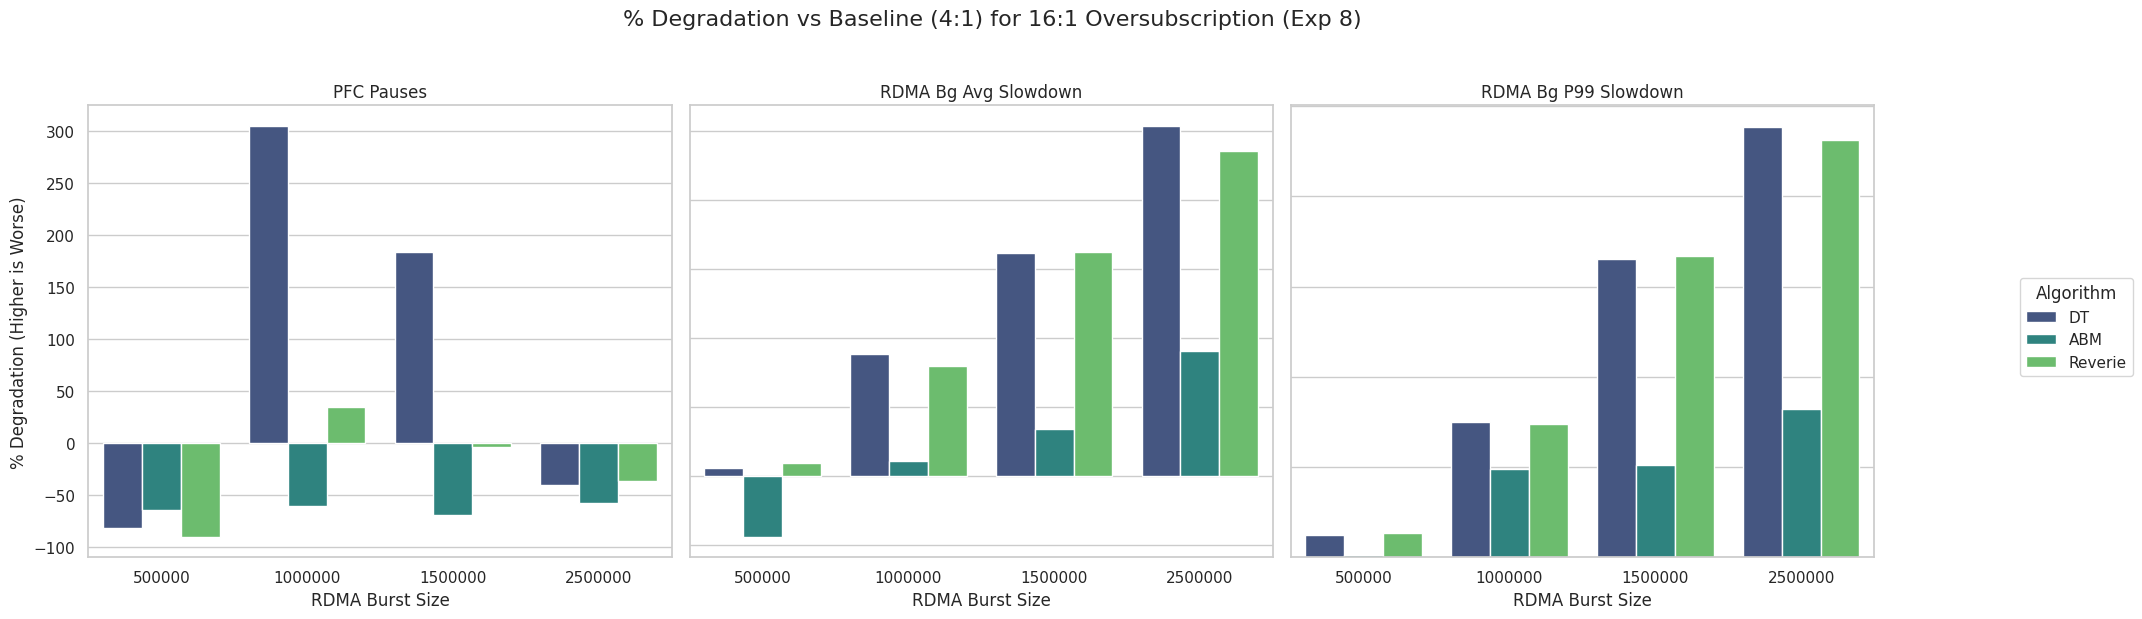


============================== End Experiment 8 Analysis ==============================


In [18]:
# --- Cell 9: Experiment 8 Analysis (Pure RDMA Burst) ---

print("\n" + "="*30 + " Experiment 8 Analysis " + "="*30)

# --- Configuration for Experiment 8 ---
exp8_filename = "exp8_pure_rdma_burst_impact.csv"

# Columns for Experiment 8
exp8_load_col = "RDMA Burst Size" # X-axis is RDMA Burst Size for Exp 8
exp8_algo_col = "Algorithm"
# Metrics based on user request and Exp 8 availability:
exp8_metric_pfc = "PFC Pauses"
# Using RDMA Background metrics as stand-ins for "incast" and "short background"
exp8_metric_rdma_bg_avg = "RDMA Background FCT Slowdown Avg"
exp8_metric_rdma_bg_p99 = "RDMA Background FCT Slowdown 99%"

# List of all metric columns needed for Exp 8
exp8_metric_cols = [exp8_metric_pfc, exp8_metric_rdma_bg_avg, exp8_metric_rdma_bg_p99]

# --- Data Loading for Experiment 8 ---
print(f"\nLoading data for Experiment 8 ({exp8_filename})...")
# Construct full paths to the specific CSV files for Exp 8
csv_path_exp8_4_1 = os.path.join(results_path_4_1, exp8_filename)
csv_path_exp8_8_1 = os.path.join(results_path_8_1, exp8_filename)
csv_path_exp8_16_1 = os.path.join(results_path_16_1, exp8_filename)

df_exp8_4_1 = load_and_prepare_data(csv_path_exp8_4_1, exp8_load_col, exp8_algo_col, exp8_metric_cols)
df_exp8_8_1 = load_and_prepare_data(csv_path_exp8_8_1, exp8_load_col, exp8_algo_col, exp8_metric_cols)
df_exp8_16_1 = load_and_prepare_data(csv_path_exp8_16_1, exp8_load_col, exp8_algo_col, exp8_metric_cols)

# Check if all dataframes loaded successfully
if df_exp8_4_1 is None or df_exp8_8_1 is None or df_exp8_16_1 is None:
    print("Error loading data for Experiment 8. Skipping analysis.")
else:
    print("Experiment 8 data loaded successfully.")

    # --- Degradation Calculation for Experiment 8 ---
    print("\nCalculating degradation for Experiment 8...")
    # 8:1 vs 4:1
    degradation_exp8_8_vs_4_pfc = calculate_degradation(df_exp8_4_1, df_exp8_8_1, exp8_metric_pfc, exp8_load_col, exp8_algo_col)
    degradation_exp8_8_vs_4_rdma_bg_avg = calculate_degradation(df_exp8_4_1, df_exp8_8_1, exp8_metric_rdma_bg_avg, exp8_load_col, exp8_algo_col)
    degradation_exp8_8_vs_4_rdma_bg_p99 = calculate_degradation(df_exp8_4_1, df_exp8_8_1, exp8_metric_rdma_bg_p99, exp8_load_col, exp8_algo_col)

    # 16:1 vs 4:1
    degradation_exp8_16_vs_4_pfc = calculate_degradation(df_exp8_4_1, df_exp8_16_1, exp8_metric_pfc, exp8_load_col, exp8_algo_col)
    degradation_exp8_16_vs_4_rdma_bg_avg = calculate_degradation(df_exp8_4_1, df_exp8_16_1, exp8_metric_rdma_bg_avg, exp8_load_col, exp8_algo_col)
    degradation_exp8_16_vs_4_rdma_bg_p99 = calculate_degradation(df_exp8_4_1, df_exp8_16_1, exp8_metric_rdma_bg_p99, exp8_load_col, exp8_algo_col)

    # --- Plotting Combined Degradation for Experiment 8 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 8 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp8_8_vs_4_pfc,
            degradation_exp8_8_vs_4_rdma_bg_avg,
            degradation_exp8_8_vs_4_rdma_bg_p99
        ],
        oversub_comparison="8:1 Oversubscription (Exp 8)",
        load_col=exp8_load_col,
        algo_col=exp8_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "RDMA Bg P99 Slowdown"] # Titles for Exp 8 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 8 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp8_16_vs_4_pfc,
            degradation_exp8_16_vs_4_rdma_bg_avg,
            degradation_exp8_16_vs_4_rdma_bg_p99
        ],
        oversub_comparison="16:1 Oversubscription (Exp 8)",
        load_col=exp8_load_col,
        algo_col=exp8_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "RDMA Bg P99 Slowdown"] # Titles for Exp 8 metrics
    )

print("\n" + "="*30 + " End Experiment 8 Analysis " + "="*30)



============================== Experiment 9 Analysis ==============================

Loading data for Experiment 9 (exp9_pure_rdma_burst_powertcp_impact.csv)...
Experiment 9 data loaded successfully.

Calculating degradation for Experiment 9...

--- Plotting Exp 9 Degradation: 8:1 vs 4:1 Baseline ---


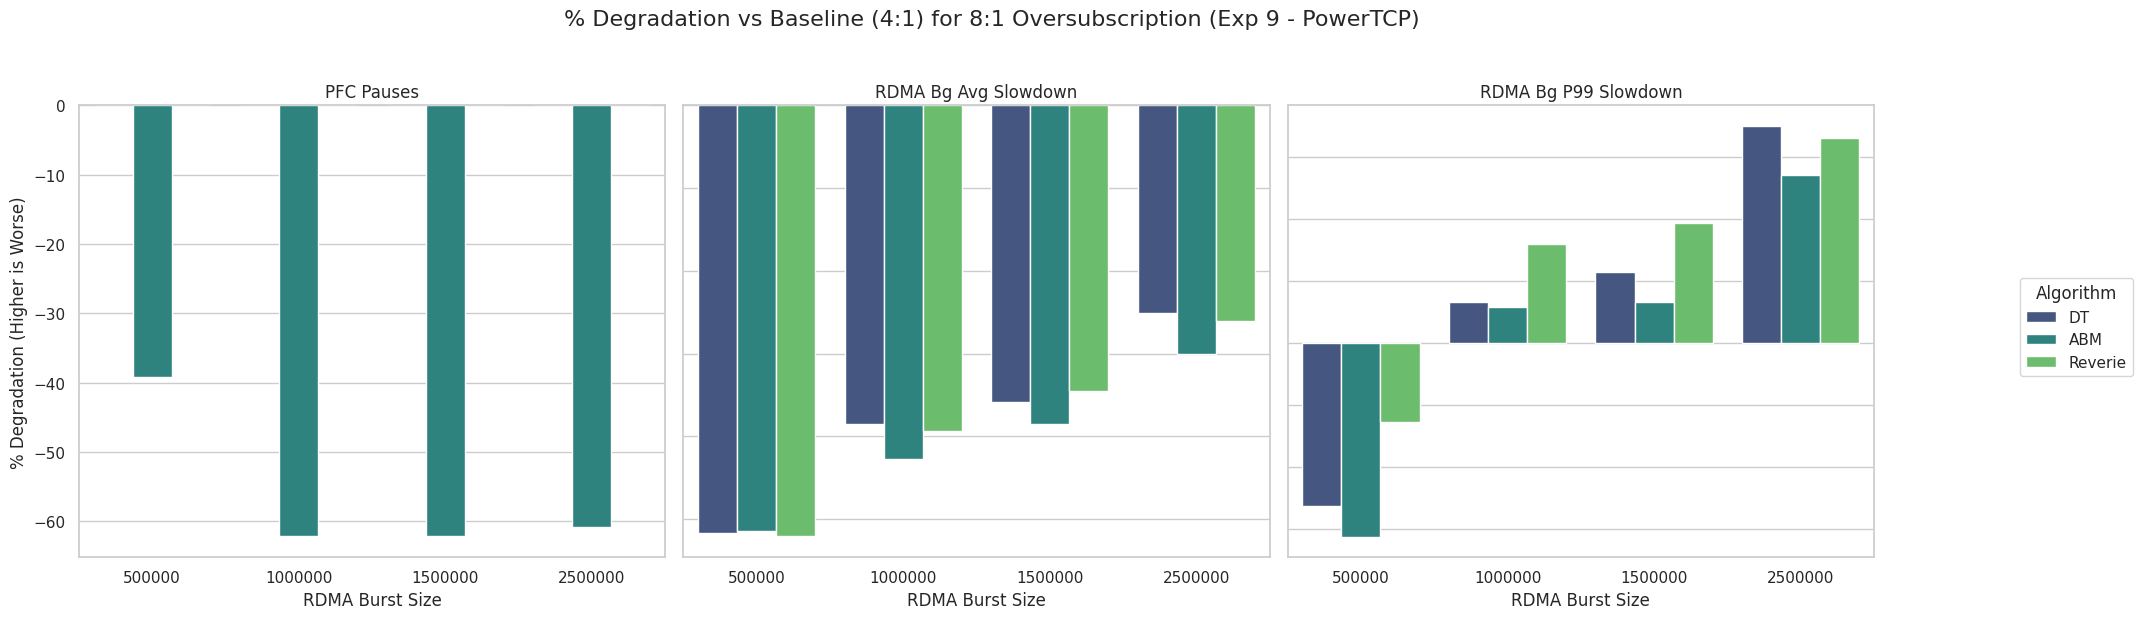


--- Plotting Exp 9 Degradation: 16:1 vs 4:1 Baseline ---


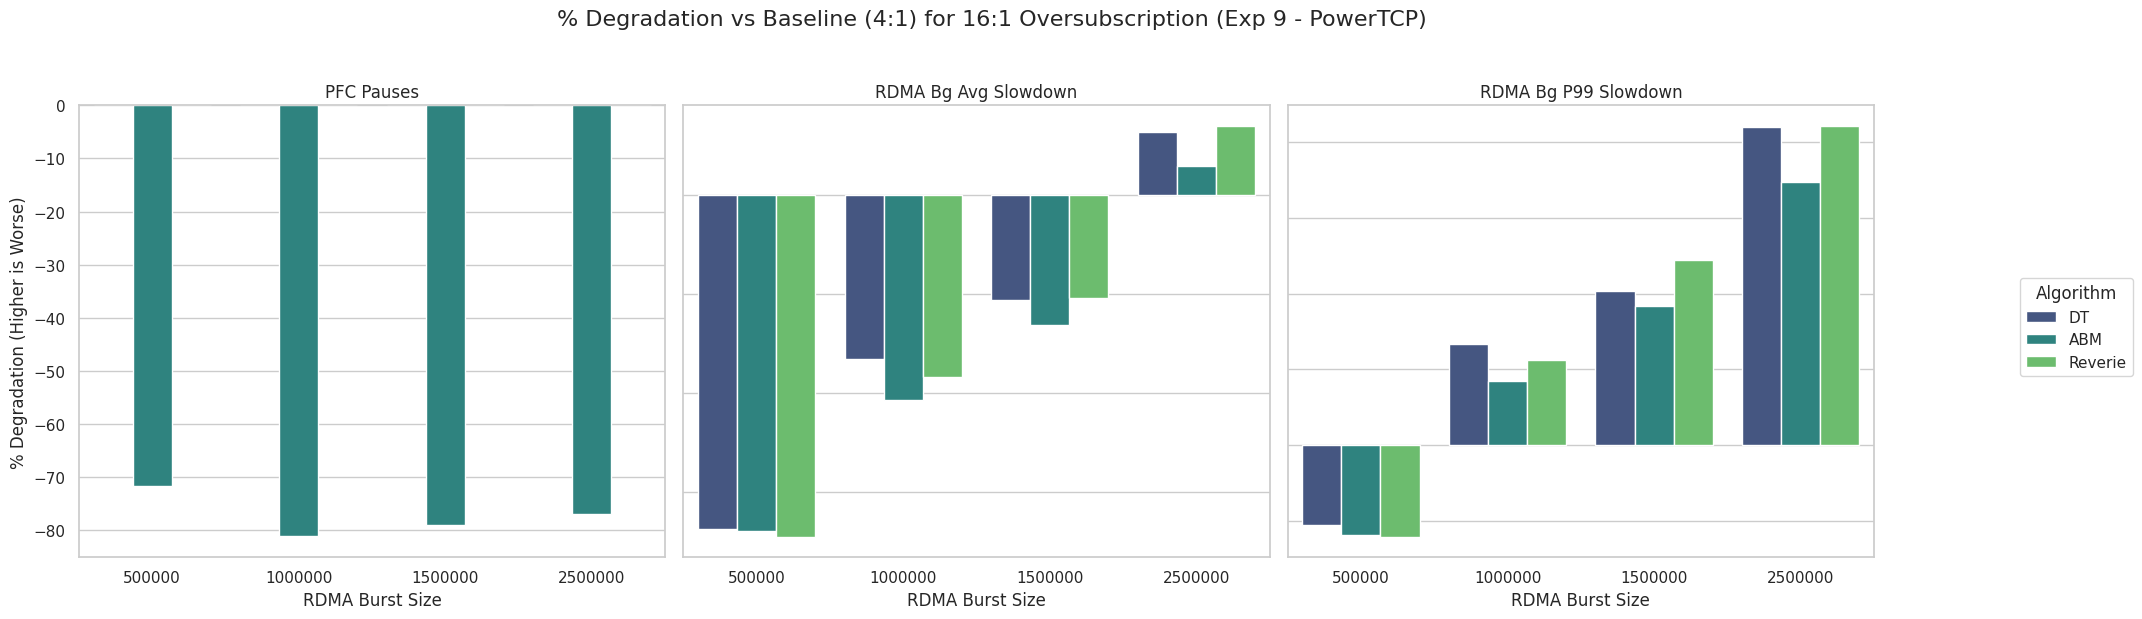


============================== End Experiment 9 Analysis ==============================


In [19]:
# --- Cell 10: Experiment 9 Analysis (Pure RDMA Burst w/ PowerTCP) ---

print("\n" + "="*30 + " Experiment 9 Analysis " + "="*30)

# --- Configuration for Experiment 9 ---
exp9_filename = "exp9_pure_rdma_burst_powertcp_impact.csv"

# Columns for Experiment 9
exp9_load_col = "RDMA Burst Size" # X-axis is RDMA Burst Size for Exp 9
exp9_algo_col = "Algorithm"
# Metrics based on user request and Exp 9 availability:
exp9_metric_pfc = "PFC Pauses"
# Using RDMA Background metrics as stand-ins for "incast" and "short background"
exp9_metric_rdma_bg_avg = "RDMA Background FCT Slowdown Avg"
exp9_metric_rdma_bg_p99 = "RDMA Background FCT Slowdown 99%"

# List of all metric columns needed for Exp 9
exp9_metric_cols = [exp9_metric_pfc, exp9_metric_rdma_bg_avg, exp9_metric_rdma_bg_p99]

# --- Data Loading for Experiment 9 ---
print(f"\nLoading data for Experiment 9 ({exp9_filename})...")
# Construct full paths to the specific CSV files for Exp 9
csv_path_exp9_4_1 = os.path.join(results_path_4_1, exp9_filename)
csv_path_exp9_8_1 = os.path.join(results_path_8_1, exp9_filename)
csv_path_exp9_16_1 = os.path.join(results_path_16_1, exp9_filename)

df_exp9_4_1 = load_and_prepare_data(csv_path_exp9_4_1, exp9_load_col, exp9_algo_col, exp9_metric_cols)
df_exp9_8_1 = load_and_prepare_data(csv_path_exp9_8_1, exp9_load_col, exp9_algo_col, exp9_metric_cols)
df_exp9_16_1 = load_and_prepare_data(csv_path_exp9_16_1, exp9_load_col, exp9_algo_col, exp9_metric_cols)

# Check if all dataframes loaded successfully
if df_exp9_4_1 is None or df_exp9_8_1 is None or df_exp9_16_1 is None:
    print("Error loading data for Experiment 9. Skipping analysis.")
else:
    print("Experiment 9 data loaded successfully.")

    # --- Degradation Calculation for Experiment 9 ---
    print("\nCalculating degradation for Experiment 9...")
    # 8:1 vs 4:1
    degradation_exp9_8_vs_4_pfc = calculate_degradation(df_exp9_4_1, df_exp9_8_1, exp9_metric_pfc, exp9_load_col, exp9_algo_col)
    degradation_exp9_8_vs_4_rdma_bg_avg = calculate_degradation(df_exp9_4_1, df_exp9_8_1, exp9_metric_rdma_bg_avg, exp9_load_col, exp9_algo_col)
    degradation_exp9_8_vs_4_rdma_bg_p99 = calculate_degradation(df_exp9_4_1, df_exp9_8_1, exp9_metric_rdma_bg_p99, exp9_load_col, exp9_algo_col)

    # 16:1 vs 4:1
    degradation_exp9_16_vs_4_pfc = calculate_degradation(df_exp9_4_1, df_exp9_16_1, exp9_metric_pfc, exp9_load_col, exp9_algo_col)
    degradation_exp9_16_vs_4_rdma_bg_avg = calculate_degradation(df_exp9_4_1, df_exp9_16_1, exp9_metric_rdma_bg_avg, exp9_load_col, exp9_algo_col)
    degradation_exp9_16_vs_4_rdma_bg_p99 = calculate_degradation(df_exp9_4_1, df_exp9_16_1, exp9_metric_rdma_bg_p99, exp9_load_col, exp9_algo_col)

    # --- Plotting Combined Degradation for Experiment 9 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 9 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp9_8_vs_4_pfc,
            degradation_exp9_8_vs_4_rdma_bg_avg,
            degradation_exp9_8_vs_4_rdma_bg_p99
        ],
        oversub_comparison="8:1 Oversubscription (Exp 9 - PowerTCP)",
        load_col=exp9_load_col,
        algo_col=exp9_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "RDMA Bg P99 Slowdown"] # Titles for Exp 9 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 9 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp9_16_vs_4_pfc,
            degradation_exp9_16_vs_4_rdma_bg_avg,
            degradation_exp9_16_vs_4_rdma_bg_p99
        ],
        oversub_comparison="16:1 Oversubscription (Exp 9 - PowerTCP)",
        load_col=exp9_load_col,
        algo_col=exp9_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "RDMA Bg P99 Slowdown"] # Titles for Exp 9 metrics
    )

print("\n" + "="*30 + " End Experiment 9 Analysis " + "="*30)





============================== Experiment 10 Analysis ==============================

Loading data for Experiment 10 (exp10_pure_tcp_load_impact.csv)...
Experiment 10 data loaded successfully.

Calculating degradation for Experiment 10...

--- Plotting Exp 10 Degradation: 8:1 vs 4:1 Baseline ---


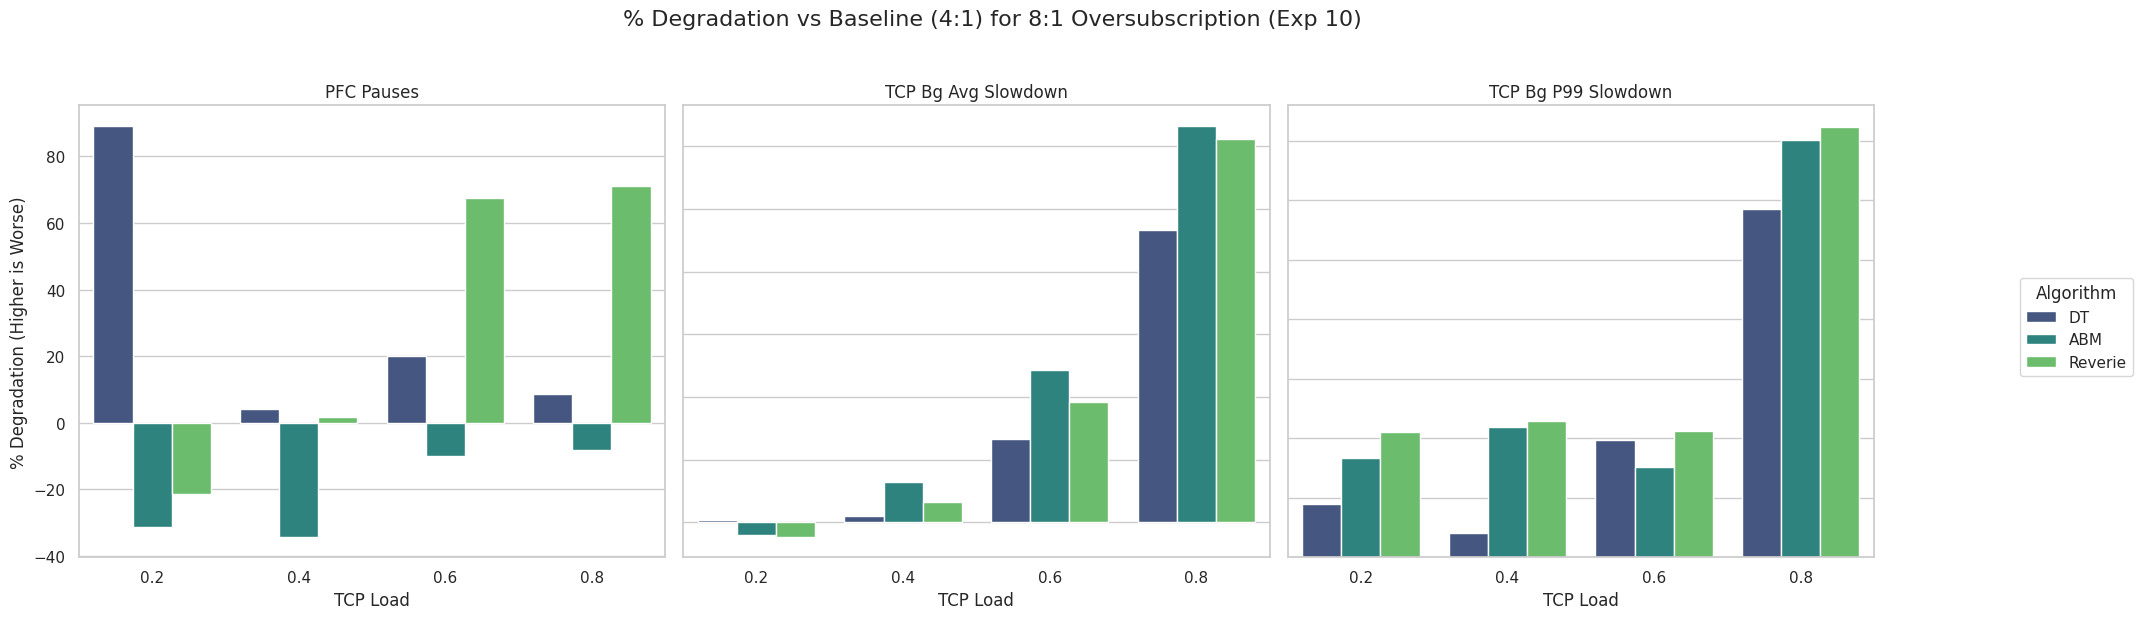


--- Plotting Exp 10 Degradation: 16:1 vs 4:1 Baseline ---


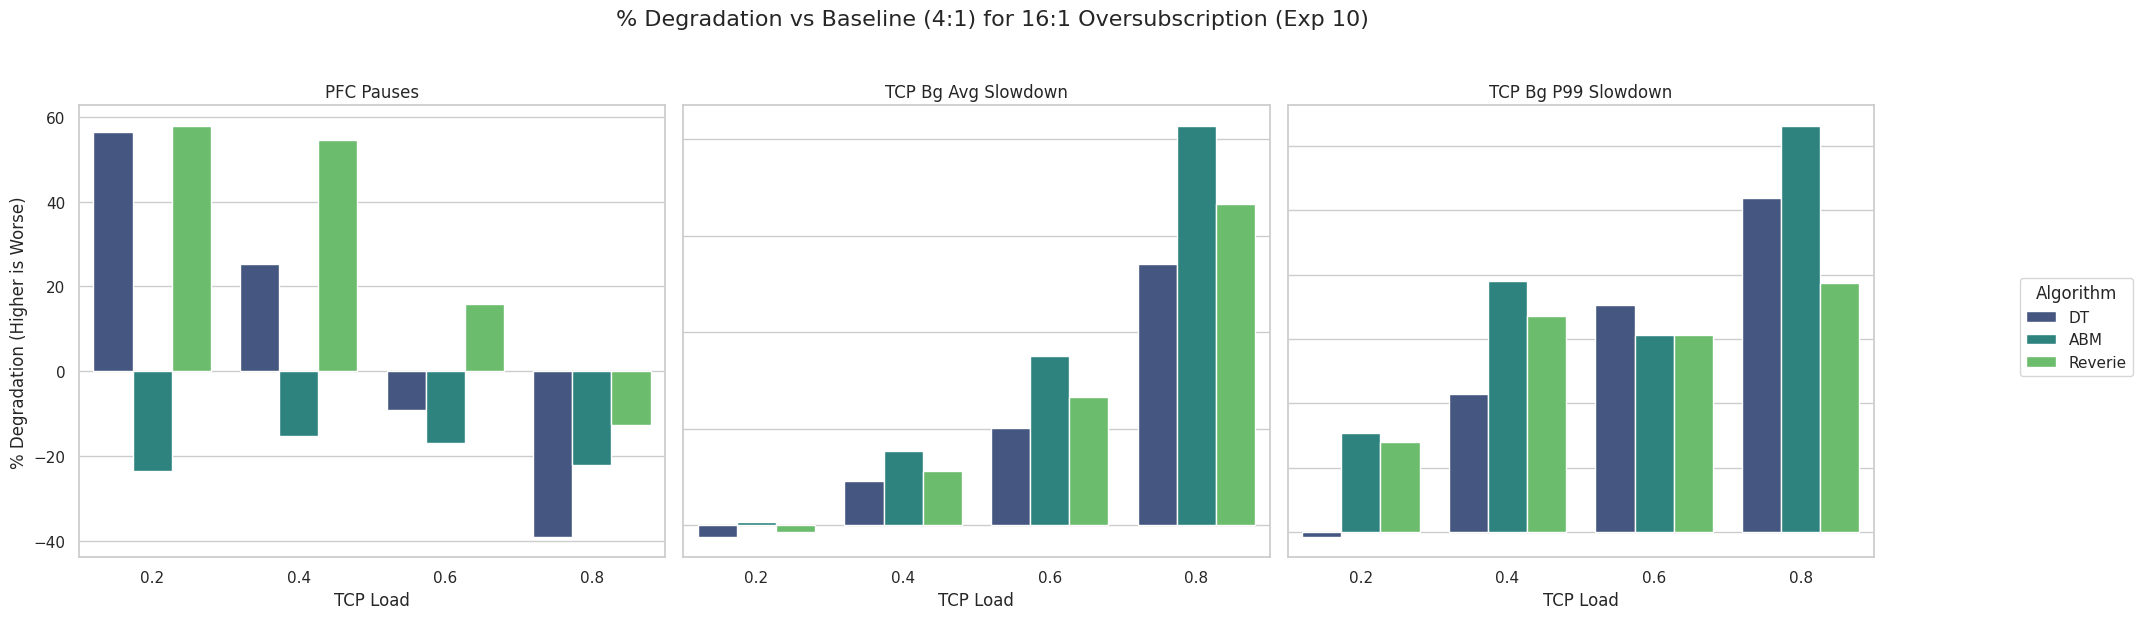


============================== End Experiment 10 Analysis ==============================


In [20]:
# --- Cell 11: Experiment 10 Analysis (Pure TCP Load) ---

print("\n" + "="*30 + " Experiment 10 Analysis " + "="*30)

# --- Configuration for Experiment 10 ---
exp10_filename = "exp10_pure_tcp_load_impact.csv"

# Columns for Experiment 10
exp10_load_col = "TCP Load" # X-axis is TCP Load for Exp 10
exp10_algo_col = "Algorithm"
# Metrics based on user request and Exp 10 availability:
exp10_metric_pfc = "PFC Pauses"
# Using TCP Background metrics as stand-ins for "incast" and "short background"
exp10_metric_tcp_bg_avg = "TCP Background FCT Slowdown Avg"
exp10_metric_tcp_bg_p99 = "TCP Background FCT Slowdown 99%"

# List of all metric columns needed for Exp 10
exp10_metric_cols = [exp10_metric_pfc, exp10_metric_tcp_bg_avg, exp10_metric_tcp_bg_p99]

# --- Data Loading for Experiment 10 ---
print(f"\nLoading data for Experiment 10 ({exp10_filename})...")
# Construct full paths to the specific CSV files for Exp 10
csv_path_exp10_4_1 = os.path.join(results_path_4_1, exp10_filename)
csv_path_exp10_8_1 = os.path.join(results_path_8_1, exp10_filename)
csv_path_exp10_16_1 = os.path.join(results_path_16_1, exp10_filename)

df_exp10_4_1 = load_and_prepare_data(csv_path_exp10_4_1, exp10_load_col, exp10_algo_col, exp10_metric_cols)
df_exp10_8_1 = load_and_prepare_data(csv_path_exp10_8_1, exp10_load_col, exp10_algo_col, exp10_metric_cols)
df_exp10_16_1 = load_and_prepare_data(csv_path_exp10_16_1, exp10_load_col, exp10_algo_col, exp10_metric_cols)

# Check if all dataframes loaded successfully
if df_exp10_4_1 is None or df_exp10_8_1 is None or df_exp10_16_1 is None:
    print("Error loading data for Experiment 10. Skipping analysis.")
else:
    print("Experiment 10 data loaded successfully.")

    # --- Degradation Calculation for Experiment 10 ---
    print("\nCalculating degradation for Experiment 10...")
    # 8:1 vs 4:1
    degradation_exp10_8_vs_4_pfc = calculate_degradation(df_exp10_4_1, df_exp10_8_1, exp10_metric_pfc, exp10_load_col, exp10_algo_col)
    degradation_exp10_8_vs_4_tcp_bg_avg = calculate_degradation(df_exp10_4_1, df_exp10_8_1, exp10_metric_tcp_bg_avg, exp10_load_col, exp10_algo_col)
    degradation_exp10_8_vs_4_tcp_bg_p99 = calculate_degradation(df_exp10_4_1, df_exp10_8_1, exp10_metric_tcp_bg_p99, exp10_load_col, exp10_algo_col)

    # 16:1 vs 4:1
    degradation_exp10_16_vs_4_pfc = calculate_degradation(df_exp10_4_1, df_exp10_16_1, exp10_metric_pfc, exp10_load_col, exp10_algo_col)
    degradation_exp10_16_vs_4_tcp_bg_avg = calculate_degradation(df_exp10_4_1, df_exp10_16_1, exp10_metric_tcp_bg_avg, exp10_load_col, exp10_algo_col)
    degradation_exp10_16_vs_4_tcp_bg_p99 = calculate_degradation(df_exp10_4_1, df_exp10_16_1, exp10_metric_tcp_bg_p99, exp10_load_col, exp10_algo_col)

    # --- Plotting Combined Degradation for Experiment 10 ---

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 10 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp10_8_vs_4_pfc,
            degradation_exp10_8_vs_4_tcp_bg_avg,
            degradation_exp10_8_vs_4_tcp_bg_p99
        ],
        oversub_comparison="8:1 Oversubscription (Exp 10)",
        load_col=exp10_load_col,
        algo_col=exp10_algo_col,
        metric_titles=["PFC Pauses", "TCP Bg Avg Slowdown", "TCP Bg P99 Slowdown"] # Titles for Exp 10 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 10 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp10_16_vs_4_pfc,
            degradation_exp10_16_vs_4_tcp_bg_avg,
            degradation_exp10_16_vs_4_tcp_bg_p99
        ],
        oversub_comparison="16:1 Oversubscription (Exp 10)",
        load_col=exp10_load_col,
        algo_col=exp10_algo_col,
        metric_titles=["PFC Pauses", "TCP Bg Avg Slowdown", "TCP Bg P99 Slowdown"] # Titles for Exp 10 metrics
    )

print("\n" + "="*30 + " End Experiment 10 Analysis " + "="*30)





============================== Experiment 11 Analysis ==============================

Loading data for Experiment 11 (exp11_rdma_tcp_interaction.csv)...
Experiment 11 data loaded successfully.

Calculating degradation for Experiment 11...

--- Plotting Exp 11 Degradation: 8:1 vs 4:1 Baseline ---


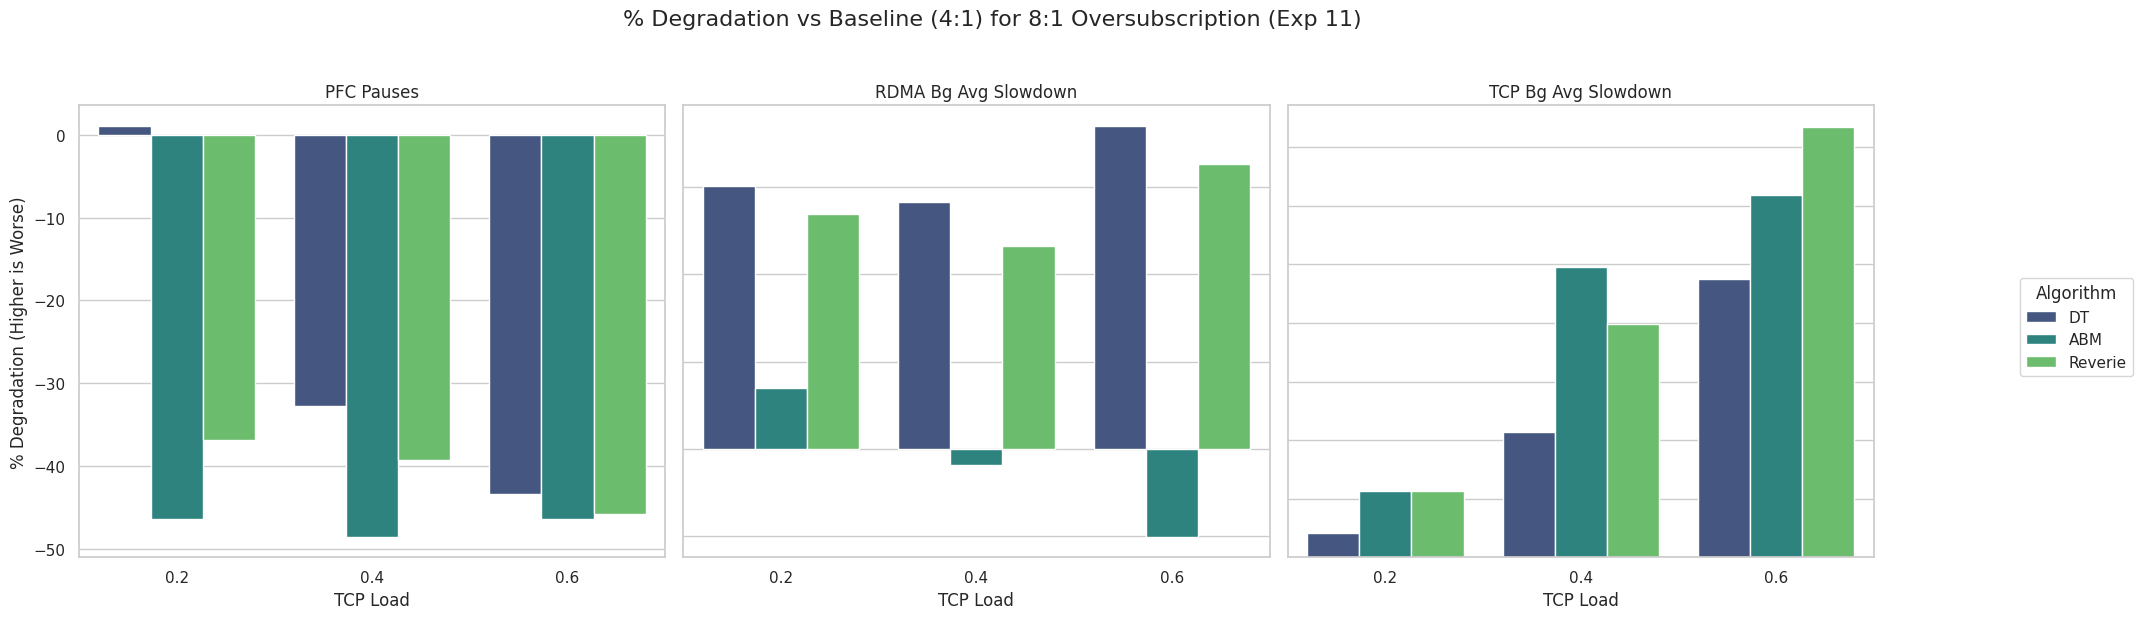


--- Plotting Exp 11 Degradation: 16:1 vs 4:1 Baseline ---


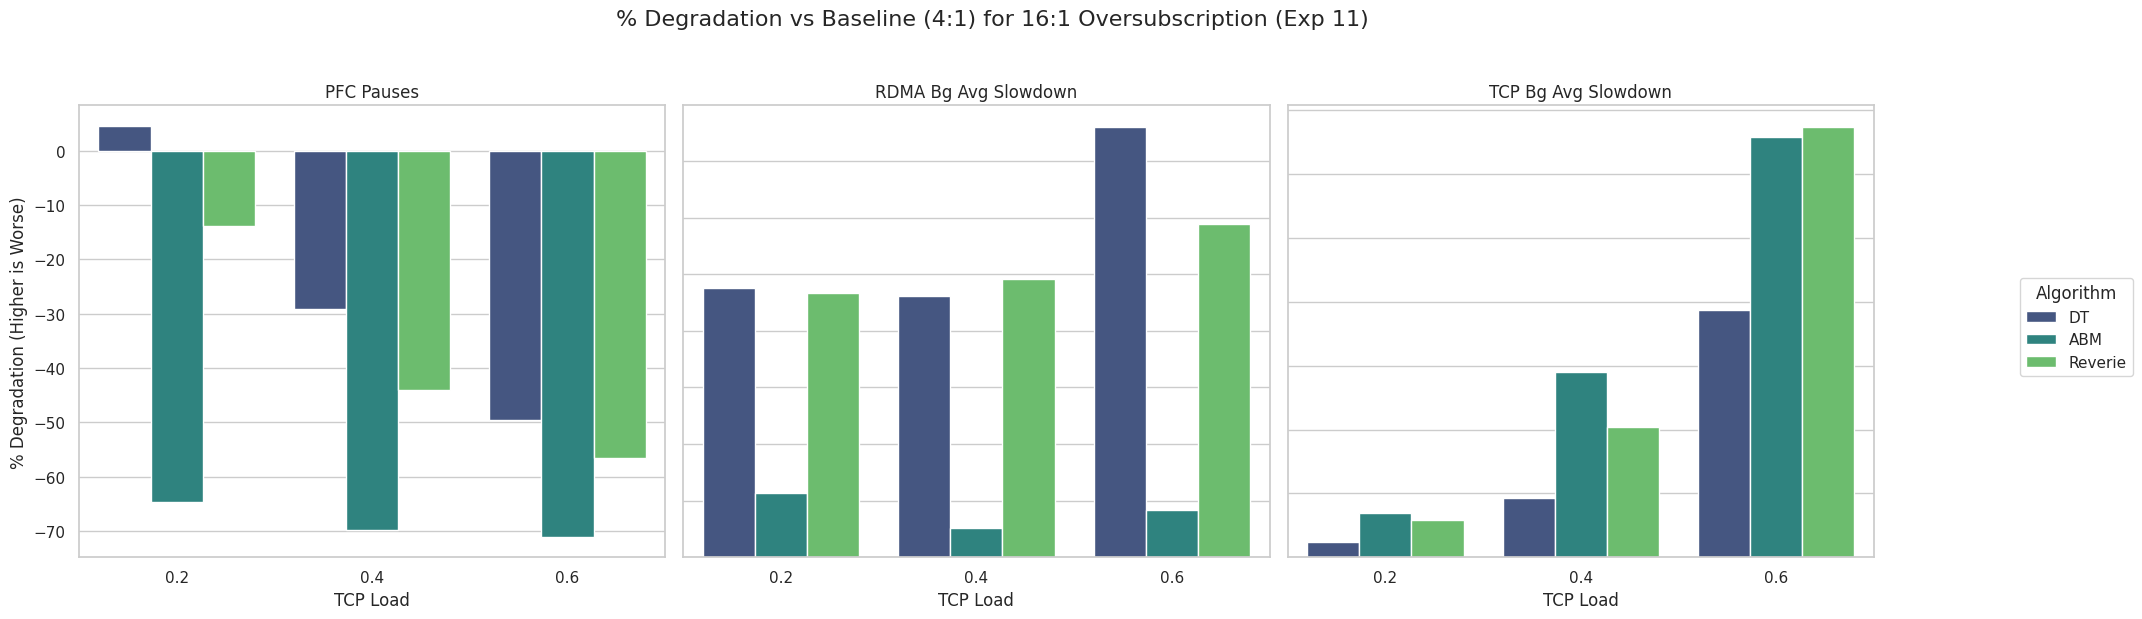


============================== End Experiment 11 Analysis ==============================


In [21]:
# --- Cell 12: Experiment 11 Analysis (RDMA/TCP Interaction) ---

print("\n" + "="*30 + " Experiment 11 Analysis " + "="*30)

# --- Configuration for Experiment 11 ---
exp11_filename = "exp11_rdma_tcp_interaction.csv"

# Columns for Experiment 11
exp11_load_col = "TCP Load" # X-axis is TCP Load for Exp 11
exp11_algo_col = "Algorithm"
# Metrics based on user request and Exp 11 availability:
exp11_metric_pfc = "PFC Pauses"
# Using RDMA and TCP Background Avg metrics. No P99 available.
exp11_metric_rdma_bg_avg = "RDMA Background FCT Slowdown Avg"
exp11_metric_tcp_bg_avg = "TCP Background FCT Slowdown Avg"

# List of all metric columns needed for Exp 11
exp11_metric_cols = [exp11_metric_pfc, exp11_metric_rdma_bg_avg, exp11_metric_tcp_bg_avg]

# --- Data Loading for Experiment 11 ---
print(f"\nLoading data for Experiment 11 ({exp11_filename})...")
# Construct full paths to the specific CSV files for Exp 11
csv_path_exp11_4_1 = os.path.join(results_path_4_1, exp11_filename)
csv_path_exp11_8_1 = os.path.join(results_path_8_1, exp11_filename)
csv_path_exp11_16_1 = os.path.join(results_path_16_1, exp11_filename)

df_exp11_4_1 = load_and_prepare_data(csv_path_exp11_4_1, exp11_load_col, exp11_algo_col, exp11_metric_cols)
df_exp11_8_1 = load_and_prepare_data(csv_path_exp11_8_1, exp11_load_col, exp11_algo_col, exp11_metric_cols)
df_exp11_16_1 = load_and_prepare_data(csv_path_exp11_16_1, exp11_load_col, exp11_algo_col, exp11_metric_cols)

# Check if all dataframes loaded successfully
if df_exp11_4_1 is None or df_exp11_8_1 is None or df_exp11_16_1 is None:
    print("Error loading data for Experiment 11. Skipping analysis.")
else:
    print("Experiment 11 data loaded successfully.")

    # --- Degradation Calculation for Experiment 11 ---
    print("\nCalculating degradation for Experiment 11...")
    # 8:1 vs 4:1
    degradation_exp11_8_vs_4_pfc = calculate_degradation(df_exp11_4_1, df_exp11_8_1, exp11_metric_pfc, exp11_load_col, exp11_algo_col)
    degradation_exp11_8_vs_4_rdma_bg_avg = calculate_degradation(df_exp11_4_1, df_exp11_8_1, exp11_metric_rdma_bg_avg, exp11_load_col, exp11_algo_col)
    degradation_exp11_8_vs_4_tcp_bg_avg = calculate_degradation(df_exp11_4_1, df_exp11_8_1, exp11_metric_tcp_bg_avg, exp11_load_col, exp11_algo_col)

    # 16:1 vs 4:1
    degradation_exp11_16_vs_4_pfc = calculate_degradation(df_exp11_4_1, df_exp11_16_1, exp11_metric_pfc, exp11_load_col, exp11_algo_col)
    degradation_exp11_16_vs_4_rdma_bg_avg = calculate_degradation(df_exp11_4_1, df_exp11_16_1, exp11_metric_rdma_bg_avg, exp11_load_col, exp11_algo_col)
    degradation_exp11_16_vs_4_tcp_bg_avg = calculate_degradation(df_exp11_4_1, df_exp11_16_1, exp11_metric_tcp_bg_avg, exp11_load_col, exp11_algo_col)

    # --- Plotting Combined Degradation for Experiment 11 ---
    # Note: Plotting only 2 FCT metrics + PFC

    # Plot for 8:1 vs 4:1
    print("\n--- Plotting Exp 11 Degradation: 8:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp11_8_vs_4_pfc,
            degradation_exp11_8_vs_4_rdma_bg_avg, # RDMA Avg
            degradation_exp11_8_vs_4_tcp_bg_avg  # TCP Avg
        ],
        oversub_comparison="8:1 Oversubscription (Exp 11)",
        load_col=exp11_load_col,
        algo_col=exp11_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "TCP Bg Avg Slowdown"] # Titles for Exp 11 metrics
    )

    # Plot for 16:1 vs 4:1
    print("\n--- Plotting Exp 11 Degradation: 16:1 vs 4:1 Baseline ---")
    plot_combined_degradation(
        degradation_data=[
            degradation_exp11_16_vs_4_pfc,
            degradation_exp11_16_vs_4_rdma_bg_avg, # RDMA Avg
            degradation_exp11_16_vs_4_tcp_bg_avg  # TCP Avg
        ],
        oversub_comparison="16:1 Oversubscription (Exp 11)",
        load_col=exp11_load_col,
        algo_col=exp11_algo_col,
        metric_titles=["PFC Pauses", "RDMA Bg Avg Slowdown", "TCP Bg Avg Slowdown"] # Titles for Exp 11 metrics
    )

print("\n" + "="*30 + " End Experiment 11 Analysis " + "="*30)